In [1]:
import matplotlib.pyplot as plt
import datetime
import os
import json
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
)
import numpy as np
import warnings
from mainGCN import *
from typing import Dict, Tuple


In [2]:
def create_metrics():
    return {"overall": {"roc_auc": [], "accuracy": [],"f1": [], "precision": [], "recall": []},
            "licit": {"precision": [], "recall": [],"f1-score": []}, 
           "illicit":{"precision": [], "recall": [],"f1-score": []}}

def hyperparameter_loop(group_para, parameter, parameter_list, metrics):
    """
    Run a grid search for a hyperparameter
    Args: hyperparameter, hyperparameter list, classification metrics (empty dict)
    Returns: Classification metrics dictionary
    """ 
    warnings.filterwarnings('ignore')
    for i in range(len(parameter_list)):
        print(f"Running {parameter} = {parameter_list[i]}")
        config[group_para][parameter] = parameter_list[i]
        
        data = load_dataset(root=config["data"]["data_root"])

        model = GCN(in_channels=data.num_features,
                    hidden_channels=config["model"]["hid_dim"],
                    num_layers=config["model"]["num_layers"],
                    out_channels=2,
                    dropout=config["model"]["dropout"],
                    )
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)

        train_loader = create_loader(
            data,
            batch_size=config["data"]["batch_size"],
            num_neighbors=config["model"]["num_neigh"],
            use_train_mask=True,
        )

        # dataset, input_nodes = load_dataset(mask="train",use_aggregated=config["data"]["use_aggregated"],use_temporal=config["data"]["use_temporal"])
        # train_loader = make_loader(data=dataset, loader_type='neighbor', batch_size=config["data"]["batch_size"], input_nodes=input_nodes)
        # # train_data = get_data_from_loader(loader)

        # mymodel = create_model(config=config["model"])

        model, training_metrics = train_model(
            model,
            train_loader,
            learning_rate=config["model"]["lr"],
            device=device,
            num_epochs=config["model"]["epoch"],
            output_directory=config["training"]["save_dir"],
            # timestamp=timestamp,
            loss_type=config["loss"]["loss_type"],
            gamma=config["loss"]["gamma"],
            beta=config["loss"]["beta"],
        )

        test_metrics = test_model(
            model,
            data,
            device,
            batch_size=config["data"]["batch_size"],
            num_neighbors=config["model"]["num_neigh"],
            output_directory=config["training"]["save_dir"],
            # threshold=config["threshold"],
            # timestamp=timestamp,
            loss_type=config["loss"]["loss_type"],
            gamma=config["loss"]["gamma"],
            beta=config["loss"]["beta"],
        )

        # trained_model = train_model(mymodel, train_loader)
    
        # dataset, input_nodes = load_dataset(mask="test",use_aggregated=config["data"]["use_aggregated"],
        # use_temporal=config["data"]["use_temporal"])
        # test_loader = make_loader(data=dataset, loader_type='neighbor', batch_size=config["data"]["batch_size"], input_nodes=input_nodes)    
        # test_data = get_data_from_loader(test_loader)

        # test_metrics = test_model(model=trained_model, data=test_data, output_directory=config["training"]["save_dir"])

        for key in list(test_metrics.keys())[0:-1]:
            metrics["overall"][key].append(test_metrics[key])
        output = test_metrics["classification_report"]
        for key in list(output["0"].keys())[0:-1]:
            metrics["licit"][key].append(output["0"][key])
            metrics["illicit"][key].append(output["1"][key])
        
    return metrics

def plot_metrics(metrics, para_list, parameter, x_log = False):
    """
    Plot the classification metrics
    Args:classification metrics
    Returns:None
    """ 

    size = (8,3)
    plt.figure(figsize= size)
    for key in list(metrics["overall"]):
        plt.plot(para_list, metrics["overall"][key], label= key)
    plt.xlabel(parameter)
    plt.ylabel("Total Metrics")
    if x_log:  plt.xscale("log")
    plt.title("Overall Classification Metrics")
    plt.legend(loc=(1.04, 0))
    plt.tight_layout()
    plt.show()

    plt.figure(figsize= size)
    for key in list(metrics["licit"]):
        plt.plot(para_list, metrics["licit"][key], label= key)
    plt.xlabel(parameter)
    plt.ylabel("Licit Metrics")
    if x_log:  plt.xscale("log")
    plt.title("Licit Classification Metrics")
    plt.legend(loc=(1.04, 0))
    plt.tight_layout()
    plt.show()

    plt.figure(figsize= size)
    for key in list(metrics["illicit"]):
        plt.plot(para_list, metrics["illicit"][key], label= key)
    plt.xlabel(parameter)
    plt.ylabel("Illicit Metrics")
    if x_log:  plt.xscale("log")
    plt.title("Illicit Classification Metrics")
    plt.legend(loc=(1.04, 0))
    plt.tight_layout()
    plt.show()


### Base GCN

In [3]:
config = {
        "model": {
            "hid_dim": 64,
            "num_layers": 2,
            "dropout": 0.0,
            "weight_decay": 0.0,
            "contamination": 0.1,
            # "backbone": "gcn",
            "lr": 0.001,
            "epoch": 10,
            "batch_size": 2048,
            "num_neigh": [10, 10],
            "weight": 0.5,
            "verbose": 1,
        },
        "data": {
            "data_root": "data/elliptic",
            "use_aggregated": False,
            "use_temporal": False,
            "batch_size": 16000
        },
        "loss": {
            "loss_type": "focal", # focal or ce
            "gamma": 1.0,
            "beta": 0.9999,
        },
        "training": {
            "save_embeddings": False,
            "save_dir": "./saved_models",
        },
        "classifiers": ["rf", "mlp"],
    }



#### Learning  Rates

In [4]:
metrics = create_metrics()
para_change = "lr"
para_list = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

Running lr = 0.0001
training with focal loss on GCN model


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:02<00:24,  2.76s/it]

Avg Batch Loss: 7.010e-01, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:05<00:21,  2.63s/it]

Avg Batch Loss: 6.782e-01, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:07<00:18,  2.60s/it]

Avg Batch Loss: 6.555e-01, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:10<00:15,  2.55s/it]

Avg Batch Loss: 6.329e-01, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:12<00:12,  2.51s/it]

Avg Batch Loss: 6.152e-01, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [00:15<00:09,  2.47s/it]

Avg Batch Loss: 5.890e-01, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [00:17<00:07,  2.50s/it]

Avg Batch Loss: 5.730e-01, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [00:20<00:04,  2.48s/it]

Avg Batch Loss: 5.512e-01, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [00:22<00:02,  2.47s/it]

Avg Batch Loss: 5.273e-01, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [00:25<00:00,  2.51s/it]

Avg Batch Loss: 5.122e-01, 
Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json


Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]



Test Metrics:
Accuracy: 0.191
F1: 0.127
Precision: 0.068
Recall: 0.943

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.14      0.25     16540
           1       0.07      0.94      0.13      1102

    accuracy                           0.19     17642
   macro avg       0.52      0.54      0.19     17642
weighted avg       0.92      0.19      0.24     17642

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.5420625245513817, 'accuracy': 0.1913615236367759, 'f1': 0.127141458639256, 'precision': 0.0681669072300223, 'recall': 0.9428312159709619, 'classification_report': {'0': {'precision': 0.97375, 'recall': 0.1412938331318017, 'f1-score': 0.246779303062302, 'support': 16540.0}, '1': {'precision': 0.0681669072300223, 'recall': 0.9428312159709619, 'f1-score': 0.127141458639256, 'support': 1102.0}, 'accuracy': 0.1913615236367759, 'macro avg': {'precision': 0.5209584536150111, 'recall': 0.5420625245513818, 'f1-s

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:02<00:23,  2.65s/it]

Avg Batch Loss: 2.081e-01, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:05<00:20,  2.54s/it]

Avg Batch Loss: 1.429e-01, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:07<00:17,  2.53s/it]

Avg Batch Loss: 1.126e-01, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:10<00:15,  2.53s/it]

Avg Batch Loss: 1.005e-01, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:12<00:12,  2.53s/it]

Avg Batch Loss: 9.537e-02, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [00:15<00:10,  2.52s/it]

Avg Batch Loss: 9.076e-02, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [00:17<00:07,  2.49s/it]

Avg Batch Loss: 8.679e-02, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [00:20<00:04,  2.49s/it]

Avg Batch Loss: 8.418e-02, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [00:22<00:02,  2.48s/it]

Avg Batch Loss: 8.062e-02, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [00:25<00:00,  2.51s/it]

Avg Batch Loss: 7.869e-02, 
Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png



Testing: 100%|██████████| 2/2 [00:02<00:00,  1.19s/it]



Test Metrics:
Accuracy: 0.488
F1: 0.178
Precision: 0.099
Recall: 0.883

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.46      0.63     16497
           1       0.10      0.88      0.18      1103

    accuracy                           0.49     17600
   macro avg       0.54      0.67      0.40     17600
weighted avg       0.93      0.49      0.60     17600

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.6721104982905488, 'accuracy': 0.48761363636363636, 'f1': 0.17763997811417107, 'precision': 0.09875291493460407, 'recall': 0.8830462375339981, 'classification_report': {'0': {'precision': 0.9833268708801861, 'recall': 0.4611747590470995, 'f1-score': 0.6278781876702154, 'support': 16497.0}, '1': {'precision': 0.09875291493460407, 'recall': 0.8830462375339981, 'f1-score': 0.17763997811417107, 'support': 1103.0}, 'accuracy': 0.48761363636363636, 'macro avg': {'precision': 0.5410398929073951, 'recall': 0.672

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:02<00:23,  2.60s/it]

Avg Batch Loss: 2.058e-01, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:05<00:20,  2.58s/it]

Avg Batch Loss: 1.082e-01, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:07<00:18,  2.59s/it]

Avg Batch Loss: 9.295e-02, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:10<00:15,  2.52s/it]

Avg Batch Loss: 7.966e-02, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:12<00:12,  2.52s/it]

Avg Batch Loss: 7.629e-02, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [00:15<00:10,  2.54s/it]

Avg Batch Loss: 7.525e-02, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [00:17<00:07,  2.58s/it]

Avg Batch Loss: 6.904e-02, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [00:20<00:05,  2.63s/it]

Avg Batch Loss: 6.364e-02, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [00:23<00:02,  2.59s/it]

Avg Batch Loss: 5.986e-02, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [00:25<00:00,  2.57s/it]

Avg Batch Loss: 5.814e-02, 
Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json


Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]



Test Metrics:
Accuracy: 0.595
F1: 0.197
Precision: 0.112
Recall: 0.795

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.58      0.73     16596
           1       0.11      0.80      0.20      1104

    accuracy                           0.60     17700
   macro avg       0.54      0.69      0.46     17700
weighted avg       0.92      0.60      0.70     17700

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.6887090393704088, 'accuracy': 0.5954237288135593, 'f1': 0.19692721767410565, 'precision': 0.11237680788429541, 'recall': 0.7952898550724637, 'classification_report': {'0': {'precision': 0.9771417012238293, 'recall': 0.5821282236683538, 'f1-score': 0.729600120832232, 'support': 16596.0}, '1': {'precision': 0.11237680788429541, 'recall': 0.7952898550724637, 'f1-score': 0.19692721767410565, 'support': 1104.0}, 'accuracy': 0.5954237288135593, 'macro avg': {'precision': 0.5447592545540624, 'recall': 0.688709

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:02<00:26,  2.90s/it]

Avg Batch Loss: 3.630e-01, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:05<00:21,  2.73s/it]

Avg Batch Loss: 1.058e-01, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:08<00:18,  2.66s/it]

Avg Batch Loss: 1.135e-01, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:10<00:15,  2.60s/it]

Avg Batch Loss: 1.041e-01, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:13<00:12,  2.57s/it]

Avg Batch Loss: 9.391e-02, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [00:15<00:10,  2.54s/it]

Avg Batch Loss: 8.351e-02, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [00:18<00:07,  2.50s/it]

Avg Batch Loss: 7.833e-02, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [00:20<00:04,  2.48s/it]

Avg Batch Loss: 7.095e-02, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [00:22<00:02,  2.49s/it]

Avg Batch Loss: 6.693e-02, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [00:25<00:00,  2.55s/it]

Avg Batch Loss: 6.372e-02, 
Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json


Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it]



Test Metrics:
Accuracy: 0.715
F1: 0.251
Precision: 0.150
Recall: 0.765

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.71      0.82     16497
           1       0.15      0.76      0.25      1100

    accuracy                           0.72     17597
   macro avg       0.56      0.74      0.54     17597
weighted avg       0.93      0.72      0.79     17597

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.7381556150705088, 'accuracy': 0.7150650679093027, 'f1': 0.251194743130227, 'precision': 0.15028591851322373, 'recall': 0.7645454545454545, 'classification_report': {'0': {'precision': 0.978418465127906, 'recall': 0.7117657755955629, 'f1-score': 0.8240578286195522, 'support': 16497.0}, '1': {'precision': 0.15028591851322373, 'recall': 0.7645454545454545, 'f1-score': 0.251194743130227, 'support': 1100.0}, 'accuracy': 0.7150650679093027, 'macro avg': {'precision': 0.5643521918205648, 'recall': 0.7381556150

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:02<00:26,  3.00s/it]

Avg Batch Loss: 3.438e-01, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:05<00:22,  2.80s/it]

Avg Batch Loss: 2.777e-01, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:08<00:19,  2.74s/it]

Avg Batch Loss: 1.399e-01, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:10<00:15,  2.65s/it]

Avg Batch Loss: 1.162e-01, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:13<00:13,  2.60s/it]

Avg Batch Loss: 1.087e-01, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [00:15<00:10,  2.57s/it]

Avg Batch Loss: 8.339e-02, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [00:18<00:07,  2.56s/it]

Avg Batch Loss: 1.537e-01, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [00:20<00:05,  2.54s/it]

Avg Batch Loss: 1.159e-01, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [00:23<00:02,  2.53s/it]

Avg Batch Loss: 1.517e-01, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [00:25<00:00,  2.59s/it]

Avg Batch Loss: 1.230e-01, 
Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png



Testing: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]



Test Metrics:
Accuracy: 0.676
F1: 0.203
Precision: 0.120
Recall: 0.658

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.68      0.80     16489
           1       0.12      0.66      0.20      1105

    accuracy                           0.68     17594
   macro avg       0.54      0.67      0.50     17594
weighted avg       0.91      0.68      0.76     17594

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.6677305780982742, 'accuracy': 0.6763101057178583, 'f1': 0.2033850888236117, 'precision': 0.12028457974851092, 'recall': 0.6579185520361991, 'classification_report': {'0': {'precision': 0.9672727272727273, 'recall': 0.6775426041603493, 'f1-score': 0.7968900460073469, 'support': 16489.0}, '1': {'precision': 0.12028457974851092, 'recall': 0.6579185520361991, 'f1-score': 0.2033850888236117, 'support': 1105.0}, 'accuracy': 0.6763101057178583, 'macro avg': {'precision': 0.543778653510619, 'recall': 0.66773057

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:02<00:23,  2.60s/it]

Avg Batch Loss: 3.221e-01, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:05<00:20,  2.60s/it]

Avg Batch Loss: 1.332e+00, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:07<00:18,  2.60s/it]

Avg Batch Loss: 7.861e-01, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:10<00:15,  2.56s/it]

Avg Batch Loss: 7.205e-01, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:12<00:12,  2.57s/it]

Avg Batch Loss: 5.374e-01, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [00:15<00:10,  2.58s/it]

Avg Batch Loss: 4.311e-01, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [00:18<00:07,  2.58s/it]

Avg Batch Loss: 3.379e-01, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [00:20<00:05,  2.58s/it]

Avg Batch Loss: 2.216e-01, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [00:23<00:02,  2.56s/it]

Avg Batch Loss: 1.766e-01, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [00:25<00:00,  2.57s/it]

Avg Batch Loss: 1.808e-01, 
Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json


Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


Test Metrics:
Accuracy: 0.761
F1: 0.162
Precision: 0.104
Recall: 0.367

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.79      0.86     16412
           1       0.10      0.37      0.16      1098

    accuracy                           0.76     17510
   macro avg       0.53      0.58      0.51     17510
weighted avg       0.90      0.76      0.82     17510

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.5773431697540605, 'accuracy': 0.7612792689891491, 'f1': 0.16165262735659847, 'precision': 0.10365226337448559, 'recall': 0.3670309653916211, 'classification_report': {'0': {'precision': 0.9489795918367347, 'recall': 0.7876553741165001, 'f1-score': 0.8608243990144503, 'support': 16412.0}, '1': {'precision': 0.10365226337448559, 'recall': 0.3670309653916211, 'f1-score': 0.16165262735659847, 'support': 1098.0}, 'accuracy': 0.7612792689891491, 'macro avg': {'precision': 0.5263159276056102, 'recall': 0.57734

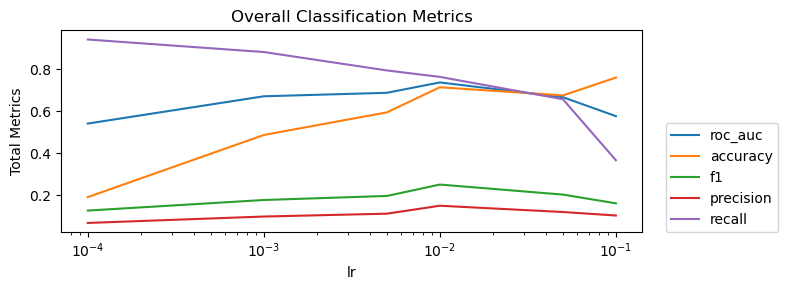

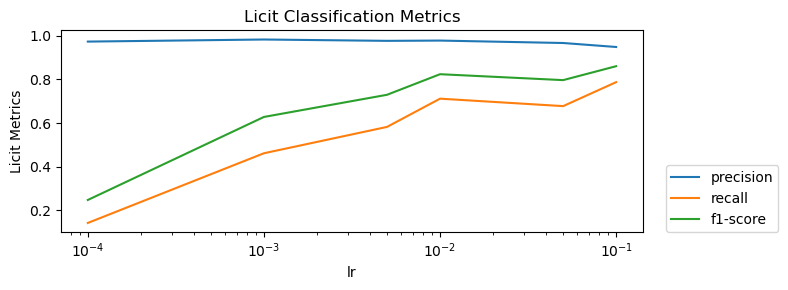

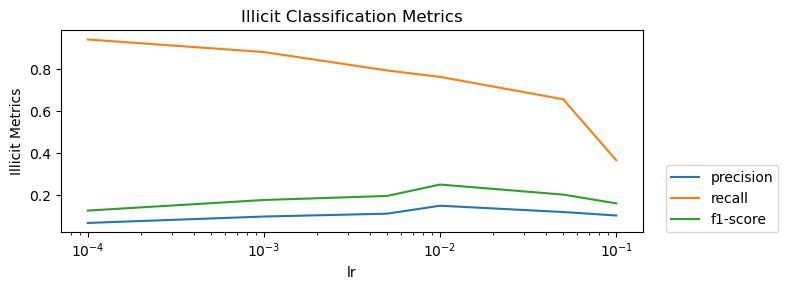

In [5]:
plot_metrics(metrics, para_list, para_change, x_log=True)

#### Number of Layers

In [6]:
metrics = create_metrics()
para_change = "num_layers"
para_list = [2, 3, 4, 5, 6, 7, 8]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)



Running num_layers = 2
training with focal loss on GCN model


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:02<00:23,  2.64s/it]

Avg Batch Loss: 2.883e-01, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:05<00:20,  2.53s/it]

Avg Batch Loss: 1.333e+00, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:07<00:17,  2.50s/it]

Avg Batch Loss: 8.415e-01, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:10<00:14,  2.48s/it]

Avg Batch Loss: 7.213e-01, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:12<00:12,  2.46s/it]

Avg Batch Loss: 5.086e-01, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [00:14<00:09,  2.45s/it]

Avg Batch Loss: 2.775e-01, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [00:17<00:07,  2.45s/it]

Avg Batch Loss: 2.534e-01, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [00:19<00:04,  2.48s/it]

Avg Batch Loss: 2.529e-01, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [00:22<00:02,  2.55s/it]

Avg Batch Loss: 1.901e-01, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [00:25<00:00,  2.51s/it]

Avg Batch Loss: 1.617e-01, 
Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png



Testing: 100%|██████████| 2/2 [00:02<00:00,  1.19s/it]



Test Metrics:
Accuracy: 0.726
F1: 0.227
Precision: 0.138
Recall: 0.643

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.73      0.83     16468
           1       0.14      0.64      0.23      1098

    accuracy                           0.73     17566
   macro avg       0.55      0.69      0.53     17566
weighted avg       0.92      0.73      0.80     17566

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.6873546886537805, 'accuracy': 0.7261755664351588, 'f1': 0.22693667630986822, 'precision': 0.1377829820452771, 'recall': 0.6429872495446266, 'classification_report': {'0': {'precision': 0.9684938112843594, 'recall': 0.7317221277629342, 'f1-score': 0.8336215842269111, 'support': 16468.0}, '1': {'precision': 0.1377829820452771, 'recall': 0.6429872495446266, 'f1-score': 0.22693667630986822, 'support': 1098.0}, 'accuracy': 0.7261755664351588, 'macro avg': {'precision': 0.5531383966648182, 'recall': 0.6873546

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:02<00:23,  2.62s/it]

Avg Batch Loss: 2.744e+01, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:05<00:21,  2.65s/it]

Avg Batch Loss: 1.447e+00, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:08<00:19,  2.73s/it]

Avg Batch Loss: 1.367e-01, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:10<00:16,  2.67s/it]

Avg Batch Loss: 1.451e-01, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:13<00:13,  2.64s/it]

Avg Batch Loss: 1.487e-01, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [00:15<00:10,  2.59s/it]

Avg Batch Loss: 1.476e-01, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [00:18<00:07,  2.57s/it]

Avg Batch Loss: 1.443e-01, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [00:20<00:05,  2.56s/it]

Avg Batch Loss: 1.387e-01, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [00:23<00:02,  2.58s/it]

Avg Batch Loss: 1.341e-01, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [00:25<00:00,  2.60s/it]


Avg Batch Loss: 1.294e-01, 
Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]



Test Metrics:
Accuracy: 0.063
F1: 0.118
Precision: 0.063
Recall: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     16441
           1       0.06      1.00      0.12      1099

    accuracy                           0.06     17540
   macro avg       0.03      0.50      0.06     17540
weighted avg       0.00      0.06      0.01     17540

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.5, 'accuracy': 0.06265678449258837, 'f1': 0.11792478137239122, 'precision': 0.06265678449258837, 'recall': 1.0, 'classification_report': {'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 16441.0}, '1': {'precision': 0.06265678449258837, 'recall': 1.0, 'f1-score': 0.11792478137239122, 'support': 1099.0}, 'accuracy': 0.06265678449258837, 'macro avg': {'precision': 0.03132839224629418, 'recall': 0.5, 'f1-score': 0.05896239068619561, 'support': 17540.0}, 'weighted avg': {'precision': 0.003

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:02<00:24,  2.70s/it]

Avg Batch Loss: 1.864e+01, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:05<00:22,  2.76s/it]

Avg Batch Loss: 6.345e-01, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:08<00:19,  2.73s/it]

Avg Batch Loss: 1.258e-01, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:10<00:15,  2.64s/it]

Avg Batch Loss: 1.341e-01, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:13<00:13,  2.61s/it]

Avg Batch Loss: 1.391e-01, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [00:15<00:10,  2.64s/it]

Avg Batch Loss: 1.381e-01, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [00:18<00:08,  2.67s/it]

Avg Batch Loss: 1.349e-01, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [00:21<00:05,  2.63s/it]

Avg Batch Loss: 1.311e-01, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [00:23<00:02,  2.59s/it]

Avg Batch Loss: 1.301e-01, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [00:26<00:00,  2.63s/it]

Avg Batch Loss: 1.293e-01, 
Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json


Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it]



Test Metrics:
Accuracy: 0.937
F1: 0.000
Precision: 0.000
Recall: 0.000

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     16490
           1       0.00      0.00      0.00      1100

    accuracy                           0.94     17590
   macro avg       0.47      0.50      0.48     17590
weighted avg       0.88      0.94      0.91     17590

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.4999696785930867, 'accuracy': 0.9374076179647527, 'f1': 0.0, 'precision': 0.0, 'recall': 0.0, 'classification_report': {'0': {'precision': 0.9374609130706691, 'recall': 0.9999393571861734, 'f1-score': 0.9676927139880865, 'support': 16490.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1100.0}, 'accuracy': 0.9374076179647527, 'macro avg': {'precision': 0.46873045653533457, 'recall': 0.4999696785930867, 'f1-score': 0.48384635699404327, 'support': 17590.0}, 'weighted avg': {'precisio

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:02<00:24,  2.73s/it]

Avg Batch Loss: 1.234e+02, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:05<00:21,  2.69s/it]

Avg Batch Loss: 3.410e+00, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:08<00:18,  2.66s/it]

Avg Batch Loss: 3.989e+00, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:10<00:15,  2.63s/it]

Avg Batch Loss: 1.635e+00, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:13<00:13,  2.61s/it]

Avg Batch Loss: 3.440e+00, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [00:15<00:10,  2.62s/it]

Avg Batch Loss: 1.082e+00, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [00:18<00:07,  2.61s/it]

Avg Batch Loss: 1.652e-01, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [00:20<00:05,  2.61s/it]

Avg Batch Loss: 2.407e-01, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [00:23<00:02,  2.60s/it]

Avg Batch Loss: 2.241e-01, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [00:26<00:00,  2.63s/it]

Avg Batch Loss: 1.317e-01, 
Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json


Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it]



Test Metrics:
Accuracy: 0.547
F1: 0.081
Precision: 0.046
Recall: 0.319

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.56      0.70     16519
           1       0.05      0.32      0.08      1102

    accuracy                           0.55     17621
   macro avg       0.49      0.44      0.39     17621
weighted avg       0.87      0.55      0.66     17621

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.44074963340349765, 'accuracy': 0.5469042619601612, 'f1': 0.08103130755064457, 'precision': 0.04640126548905879, 'recall': 0.3194192377495463, 'classification_report': {'0': {'precision': 0.9252615844544095, 'recall': 0.562080029057449, 'f1-score': 0.6993296678466521, 'support': 16519.0}, '1': {'precision': 0.04640126548905879, 'recall': 0.3194192377495463, 'f1-score': 0.08103130755064457, 'support': 1102.0}, 'accuracy': 0.5469042619601612, 'macro avg': {'precision': 0.48583142497173415, 'recall': 0.4407

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:02<00:25,  2.79s/it]

Avg Batch Loss: 2.197e+02, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:05<00:21,  2.70s/it]

Avg Batch Loss: 1.006e+00, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:08<00:18,  2.71s/it]

Avg Batch Loss: 2.777e-01, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:10<00:16,  2.69s/it]

Avg Batch Loss: 1.635e-01, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:13<00:13,  2.67s/it]

Avg Batch Loss: 1.397e-01, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [00:16<00:10,  2.68s/it]

Avg Batch Loss: 1.451e-01, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [00:18<00:07,  2.66s/it]

Avg Batch Loss: 1.409e-01, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [00:21<00:05,  2.70s/it]

Avg Batch Loss: 1.405e-01, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [00:24<00:02,  2.72s/it]

Avg Batch Loss: 1.371e-01, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [00:26<00:00,  2.70s/it]

Avg Batch Loss: 1.388e-01, 
Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json


Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]



Test Metrics:
Accuracy: 0.195
F1: 0.096
Precision: 0.051
Recall: 0.679

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.16      0.27     16499
           1       0.05      0.68      0.10      1103

    accuracy                           0.19     17602
   macro avg       0.47      0.42      0.18     17602
weighted avg       0.83      0.19      0.26     17602

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.42071529706709876, 'accuracy': 0.19475059652312238, 'f1': 0.09558448187850944, 'precision': 0.051410529205848036, 'recall': 0.6790571169537625, 'classification_report': {'0': {'precision': 0.8832838773491593, 'recall': 0.16237347718043518, 'f1-score': 0.27431906614785995, 'support': 16499.0}, '1': {'precision': 0.051410529205848036, 'recall': 0.6790571169537625, 'f1-score': 0.09558448187850944, 'support': 1103.0}, 'accuracy': 0.19475059652312238, 'macro avg': {'precision': 0.4673472032775036, 'recall': 

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:02<00:25,  2.81s/it]

Avg Batch Loss: 6.445e+01, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:05<00:22,  2.77s/it]

Avg Batch Loss: 1.811e-01, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:08<00:19,  2.72s/it]

Avg Batch Loss: 1.293e-01, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:10<00:16,  2.71s/it]

Avg Batch Loss: 1.321e-01, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:13<00:13,  2.69s/it]

Avg Batch Loss: 1.303e-01, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [00:16<00:10,  2.67s/it]

Avg Batch Loss: 1.243e-01, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [00:18<00:08,  2.69s/it]

Avg Batch Loss: 1.176e-01, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [00:21<00:05,  2.70s/it]

Avg Batch Loss: 1.162e-01, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [00:24<00:02,  2.70s/it]

Avg Batch Loss: 1.161e-01, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [00:27<00:00,  2.71s/it]

Avg Batch Loss: 1.152e-01, 
Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json


Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it]



Test Metrics:
Accuracy: 0.666
F1: 0.209
Precision: 0.123
Recall: 0.695

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.66      0.79     16495
           1       0.12      0.69      0.21      1118

    accuracy                           0.67     17613
   macro avg       0.55      0.68      0.50     17613
weighted avg       0.92      0.67      0.75     17613

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.6797780375795559, 'accuracy': 0.6664963379322092, 'f1': 0.20920840064620355, 'precision': 0.1231378763866878, 'recall': 0.6949910554561717, 'classification_report': {'0': {'precision': 0.969831018313722, 'recall': 0.6645650197029402, 'f1-score': 0.7886898338009929, 'support': 16495.0}, '1': {'precision': 0.1231378763866878, 'recall': 0.6949910554561717, 'f1-score': 0.20920840064620355, 'support': 1118.0}, 'accuracy': 0.6664963379322092, 'macro avg': {'precision': 0.5464844473502048, 'recall': 0.67977803

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:02<00:25,  2.85s/it]

Avg Batch Loss: 3.432e+02, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:05<00:22,  2.82s/it]

Avg Batch Loss: 2.531e-01, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:08<00:19,  2.78s/it]

Avg Batch Loss: 1.219e+01, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:11<00:16,  2.76s/it]

Avg Batch Loss: 1.341e+00, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:13<00:13,  2.74s/it]

Avg Batch Loss: 2.133e-01, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [00:16<00:10,  2.73s/it]

Avg Batch Loss: 1.636e-01, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [00:19<00:08,  2.73s/it]

Avg Batch Loss: 2.225e-01, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [00:21<00:05,  2.71s/it]

Avg Batch Loss: 1.907e-01, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [00:24<00:02,  2.72s/it]

Avg Batch Loss: 1.342e-01, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [00:27<00:00,  2.74s/it]

Avg Batch Loss: 1.298e-01, 
Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json


Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


Test Metrics:
Accuracy: 0.432
F1: 0.162
Precision: 0.089
Recall: 0.883

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.40      0.57     16514
           1       0.09      0.88      0.16      1098

    accuracy                           0.43     17612
   macro avg       0.54      0.64      0.37     17612
weighted avg       0.93      0.43      0.54     17612

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.6426931898374906, 'accuracy': 0.43197819668407905, 'f1': 0.16242464835900872, 'precision': 0.08943389267932879, 'recall': 0.8834244080145719, 'classification_report': {'0': {'precision': 0.9810818799881762, 'recall': 0.40196197166040937, 'f1-score': 0.570274914089347, 'support': 16514.0}, '1': {'precision': 0.08943389267932879, 'recall': 0.8834244080145719, 'f1-score': 0.16242464835900872, 'support': 1098.0}, 'accuracy': 0.43197819668407905, 'macro avg': {'precision': 0.5352578863337525, 'recall': 0.642

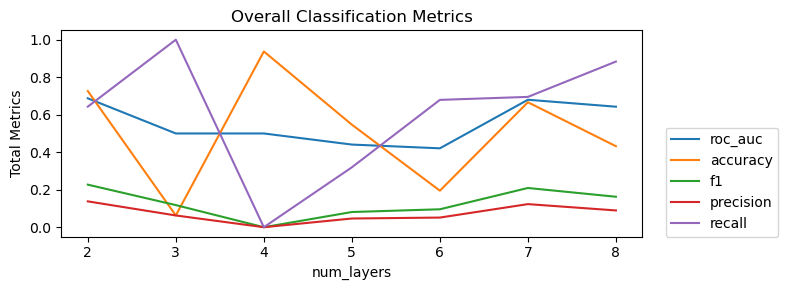

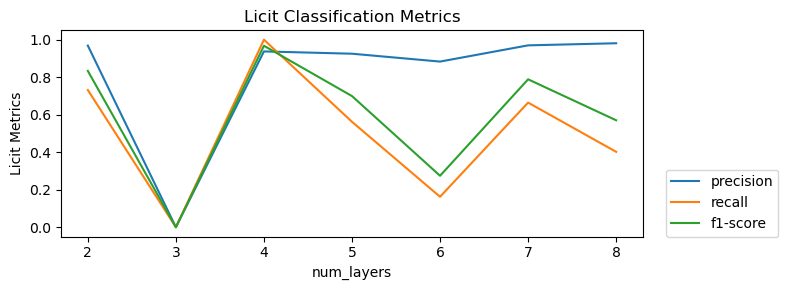

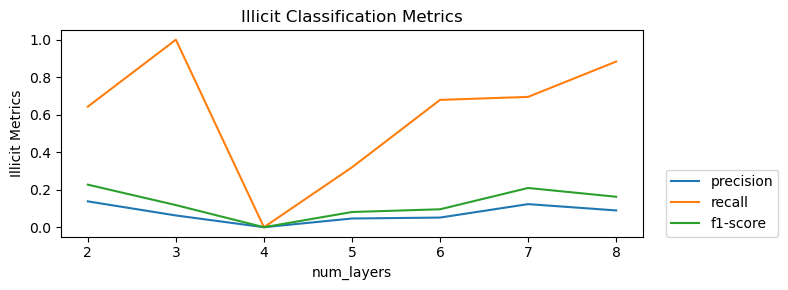

In [7]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Hidden Dimension


In [8]:
metrics = create_metrics()
para_change = "hid_dim"
para_list = [32, 64, 128, 256, 512, 1024]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

Running hid_dim = 32
training with focal loss on GCN model


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:02<00:24,  2.67s/it]

Avg Batch Loss: 1.491e+01, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:05<00:21,  2.64s/it]

Avg Batch Loss: 1.776e-01, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:07<00:18,  2.64s/it]

Avg Batch Loss: 1.436e-01, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:10<00:15,  2.64s/it]

Avg Batch Loss: 1.224e-01, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:13<00:13,  2.60s/it]

Avg Batch Loss: 1.191e-01, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [00:15<00:10,  2.59s/it]

Avg Batch Loss: 1.102e-01, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [00:18<00:07,  2.61s/it]

Avg Batch Loss: 1.186e-01, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [00:21<00:05,  2.64s/it]

Avg Batch Loss: 1.239e-01, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [00:23<00:02,  2.66s/it]

Avg Batch Loss: 1.142e-01, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [00:26<00:00,  2.65s/it]

Avg Batch Loss: 1.113e-01, 
Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json


Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it]



Test Metrics:
Accuracy: 0.333
F1: 0.138
Precision: 0.075
Recall: 0.864

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.30      0.46     16516
           1       0.08      0.86      0.14      1093

    accuracy                           0.33     17609
   macro avg       0.52      0.58      0.30     17609
weighted avg       0.91      0.33      0.44     17609

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.5805735357236002, 'accuracy': 0.3326140042023965, 'f1': 0.13841642228739004, 'precision': 0.07523710847214474, 'recall': 0.8636779505946935, 'classification_report': {'0': {'precision': 0.9705649940734887, 'recall': 0.29746912085250665, 'f1-score': 0.4553712114190379, 'support': 16516.0}, '1': {'precision': 0.07523710847214474, 'recall': 0.8636779505946935, 'f1-score': 0.13841642228739004, 'support': 1093.0}, 'accuracy': 0.3326140042023965, 'macro avg': {'precision': 0.5229010512728167, 'recall': 0.5805

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:02<00:26,  2.90s/it]

Avg Batch Loss: 1.014e+01, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:05<00:23,  2.98s/it]

Avg Batch Loss: 2.925e+02, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:08<00:20,  2.89s/it]

Avg Batch Loss: 1.425e+00, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:11<00:17,  2.88s/it]

Avg Batch Loss: 2.584e-01, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:14<00:14,  2.82s/it]

Avg Batch Loss: 1.495e-01, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [00:17<00:11,  2.82s/it]

Avg Batch Loss: 1.355e-01, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [00:19<00:08,  2.79s/it]

Avg Batch Loss: 1.346e-01, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [00:22<00:05,  2.76s/it]

Avg Batch Loss: 1.346e-01, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [00:25<00:02,  2.73s/it]

Avg Batch Loss: 1.321e-01, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [00:28<00:00,  2.81s/it]

Avg Batch Loss: 1.314e-01, 
Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json


Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it]



Test Metrics:
Accuracy: 0.120
F1: 0.117
Precision: 0.062
Recall: 0.937

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.07      0.12     16505
           1       0.06      0.94      0.12      1097

    accuracy                           0.12     17602
   macro avg       0.50      0.50      0.12     17602
weighted avg       0.89      0.12      0.12     17602

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.5013891263027115, 'accuracy': 0.11998636518577434, 'f1': 0.11717770432007295, 'precision': 0.062496200376922606, 'recall': 0.9371011850501367, 'classification_report': {'0': {'precision': 0.9401561144839549, 'recall': 0.06567706755528628, 'f1-score': 0.12277721146222675, 'support': 16505.0}, '1': {'precision': 0.062496200376922606, 'recall': 0.9371011850501367, 'f1-score': 0.11717770432007295, 'support': 1097.0}, 'accuracy': 0.11998636518577434, 'macro avg': {'precision': 0.5013261574304387, 'recall': 0

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:03<00:27,  3.05s/it]

Avg Batch Loss: 4.659e+04, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:06<00:24,  3.03s/it]

Avg Batch Loss: 2.337e+02, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:09<00:21,  3.01s/it]

Avg Batch Loss: 1.613e+03, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:12<00:17,  2.99s/it]

Avg Batch Loss: 2.823e+00, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:15<00:15,  3.01s/it]

Avg Batch Loss: 2.050e-01, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [00:18<00:12,  3.04s/it]

Avg Batch Loss: 1.438e-01, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [00:21<00:09,  3.02s/it]

Avg Batch Loss: 1.475e-01, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [00:24<00:06,  3.02s/it]

Avg Batch Loss: 1.406e-01, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [00:27<00:03,  3.05s/it]

Avg Batch Loss: 1.387e-01, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [00:30<00:00,  3.02s/it]

Avg Batch Loss: 1.374e-01, 
Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json


Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]



Test Metrics:
Accuracy: 0.174
F1: 0.094
Precision: 0.051
Recall: 0.686

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.14      0.24     16484
           1       0.05      0.69      0.09      1099

    accuracy                           0.17     17583
   macro avg       0.46      0.41      0.17     17583
weighted avg       0.82      0.17      0.23     17583

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.41319806848298485, 'accuracy': 0.17442984701131775, 'f1': 0.09410883674488267, 'precision': 0.05051926298157454, 'recall': 0.6860782529572339, 'classification_report': {'0': {'precision': 0.8702031602708804, 'recall': 0.14031788400873574, 'f1-score': 0.24166753735241878, 'support': 16484.0}, '1': {'precision': 0.05051926298157454, 'recall': 0.6860782529572339, 'f1-score': 0.09410883674488267, 'support': 1099.0}, 'accuracy': 0.17442984701131775, 'macro avg': {'precision': 0.46036121162622745, 'recall': 0

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:03<00:34,  3.83s/it]

Avg Batch Loss: 3.759e+06, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:07<00:29,  3.72s/it]

Avg Batch Loss: 3.486e+03, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:11<00:25,  3.67s/it]

Avg Batch Loss: 6.466e+04, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:14<00:21,  3.64s/it]

Avg Batch Loss: 1.271e+04, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:18<00:18,  3.62s/it]

Avg Batch Loss: 3.629e+03, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [00:21<00:14,  3.61s/it]

Avg Batch Loss: 5.315e+03, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [00:25<00:10,  3.61s/it]

Avg Batch Loss: 2.204e+03, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [00:29<00:07,  3.60s/it]

Avg Batch Loss: 2.200e+03, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [00:32<00:03,  3.61s/it]

Avg Batch Loss: 6.324e+03, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [00:36<00:00,  3.63s/it]

Avg Batch Loss: 4.721e+03, 
Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json


Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]



Test Metrics:
Accuracy: 0.937
F1: 0.000
Precision: 0.000
Recall: 0.000

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     16538
           1       0.00      0.00      0.00      1103

    accuracy                           0.94     17641
   macro avg       0.47      0.50      0.48     17641
weighted avg       0.88      0.94      0.91     17641

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.5, 'accuracy': 0.9374751998186044, 'f1': 0.0, 'precision': 0.0, 'recall': 0.0, 'classification_report': {'0': {'precision': 0.9374751998186044, 'recall': 1.0, 'f1-score': 0.9677287223148717, 'support': 16538.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1103.0}, 'accuracy': 0.9374751998186044, 'macro avg': {'precision': 0.4687375999093022, 'recall': 0.5, 'f1-score': 0.48386436115743586, 'support': 17641.0}, 'weighted avg': {'precision': 0.8788597502749322, 'recall': 0.9374751998

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:05<00:49,  5.53s/it]

Avg Batch Loss: 3.621e+08, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:11<00:47,  5.92s/it]

Avg Batch Loss: 2.584e+05, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:17<00:39,  5.65s/it]

Avg Batch Loss: 3.500e+06, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:22<00:33,  5.52s/it]

Avg Batch Loss: 2.418e+05, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:27<00:27,  5.47s/it]

Avg Batch Loss: 2.209e+04, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [00:33<00:21,  5.45s/it]

Avg Batch Loss: 2.186e+04, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [00:38<00:16,  5.50s/it]

Avg Batch Loss: 6.829e+05, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [00:44<00:11,  5.51s/it]

Avg Batch Loss: 4.616e+04, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [00:49<00:05,  5.50s/it]

Avg Batch Loss: 5.801e+04, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [00:55<00:00,  5.53s/it]

Avg Batch Loss: 3.766e+04, 
Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json


Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]



Test Metrics:
Accuracy: 0.937
F1: 0.000
Precision: 0.000
Recall: 0.000

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     16573
           1       0.00      0.00      0.00      1108

    accuracy                           0.94     17681
   macro avg       0.47      0.50      0.48     17681
weighted avg       0.88      0.94      0.91     17681

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.5, 'accuracy': 0.9373338612069453, 'f1': 0.0, 'precision': 0.0, 'recall': 0.0, 'classification_report': {'0': {'precision': 0.9373338612069453, 'recall': 1.0, 'f1-score': 0.967653412740118, 'support': 16573.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1108.0}, 'accuracy': 0.9373338612069453, 'macro avg': {'precision': 0.46866693060347264, 'recall': 0.5, 'f1-score': 0.483826706370059, 'support': 17681.0}, 'weighted avg': {'precision': 0.878594767365121, 'recall': 0.9373338612069

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:10<01:36, 10.70s/it]

Avg Batch Loss: 4.394e+10, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:21<01:23, 10.47s/it]

Avg Batch Loss: 2.336e+08, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:31<01:12, 10.29s/it]

Avg Batch Loss: 4.412e+07, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:41<01:02, 10.38s/it]

Avg Batch Loss: 2.949e+07, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:51<00:51, 10.29s/it]

Avg Batch Loss: 9.094e+06, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [01:01<00:40, 10.06s/it]

Avg Batch Loss: 1.098e+06, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [01:11<00:29,  9.94s/it]

Avg Batch Loss: 7.857e+05, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [01:20<00:19,  9.86s/it]

Avg Batch Loss: 5.092e+05, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [01:30<00:09,  9.72s/it]

Avg Batch Loss: 3.193e+06, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [01:39<00:00,  9.95s/it]

Avg Batch Loss: 1.048e+05, 


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


Test Metrics:
Accuracy: 0.927
F1: 0.075
Precision: 0.188
Recall: 0.047

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     16370
           1       0.19      0.05      0.08      1106

    accuracy                           0.93     17476
   macro avg       0.56      0.52      0.52     17476
weighted avg       0.89      0.93      0.91     17476

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.5166663536814244, 'accuracy': 0.9268711375600824, 'f1': 0.07525325615050651, 'precision': 0.18840579710144928, 'recall': 0.04701627486437613, 'classification_report': {'0': {'precision': 0.9387209302325581, 'recall': 0.9863164324984728, 'f1-score': 0.9619302949061662, 'support': 16370.0}, '1': {'precision': 0.18840579710144928, 'recall': 0.04701627486437613, 'f1-score': 0.07525325615050651, 'support': 1106.0}, 'accuracy': 0.9268711375600824, 'macro avg': {'precision': 0.5635633636670037, 'recall': 0.516

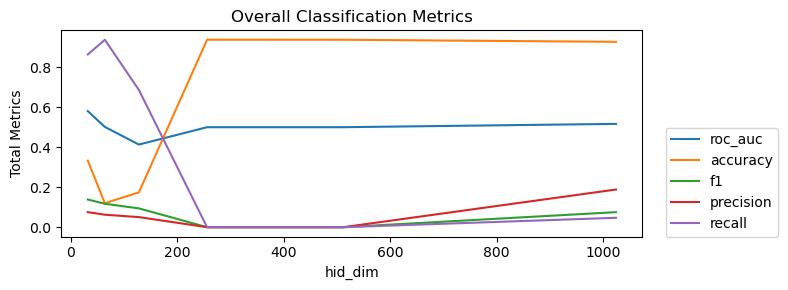

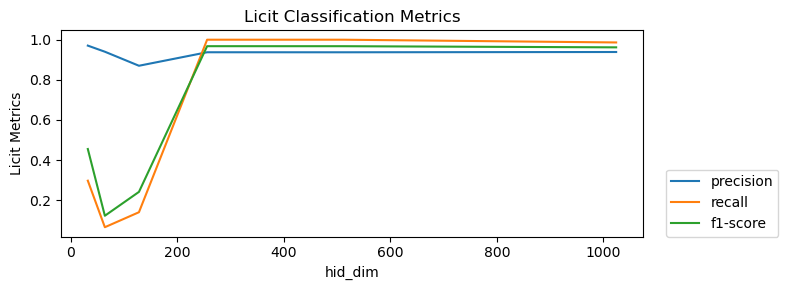

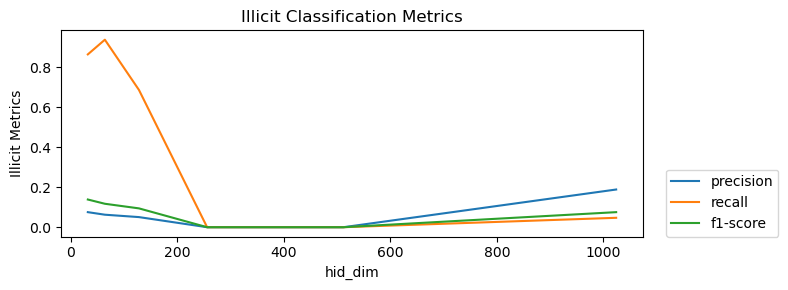

In [9]:
plot_metrics(metrics, para_list, para_change, x_log=False)

#### Dropout

In [10]:
metrics = create_metrics()
para_change = "dropout"
para_list = [0.0, 0.01, 0.1, 0.2]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

Running dropout = 0.0
training with focal loss on GCN model


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:09<01:25,  9.47s/it]

Avg Batch Loss: 2.528e+10, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:18<01:13,  9.20s/it]

Avg Batch Loss: 5.991e+08, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:27<01:04,  9.21s/it]

Avg Batch Loss: 1.284e+09, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:36<00:54,  9.15s/it]

Avg Batch Loss: 1.799e+06, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:45<00:45,  9.14s/it]

Avg Batch Loss: 4.824e+07, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [00:55<00:37,  9.29s/it]

Avg Batch Loss: 2.808e+06, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [01:04<00:27,  9.33s/it]

Avg Batch Loss: 1.671e+07, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [01:14<00:18,  9.40s/it]

Avg Batch Loss: 9.659e+06, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [01:23<00:09,  9.35s/it]

Avg Batch Loss: 5.730e+06, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [01:32<00:00,  9.27s/it]

Avg Batch Loss: 3.724e+06, 


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:03<00:00,  1.68s/it]



Test Metrics:
Accuracy: 0.937
F1: 0.000
Precision: 0.000
Recall: 0.000

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     16445
           1       0.00      0.00      0.00      1108

    accuracy                           0.94     17553
   macro avg       0.47      0.50      0.48     17553
weighted avg       0.88      0.94      0.91     17553

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.5, 'accuracy': 0.9368768871417992, 'f1': 0.0, 'precision': 0.0, 'recall': 0.0, 'classification_report': {'0': {'precision': 0.9368768871417992, 'recall': 1.0, 'f1-score': 0.9674098476380963, 'support': 16445.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1108.0}, 'accuracy': 0.9368768871417992, 'macro avg': {'precision': 0.4684384435708996, 'recall': 0.5, 'f1-score': 0.48370492381904817, 'support': 17553.0}, 'weighted avg': {'precision': 0.8777383016605075, 'recall': 0.9368768871

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:13<02:03, 13.75s/it]

Avg Batch Loss: 1.051e+09, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:28<01:55, 14.45s/it]

Avg Batch Loss: 3.617e+08, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:42<01:39, 14.20s/it]

Avg Batch Loss: 2.421e+08, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:56<01:23, 13.94s/it]

Avg Batch Loss: 1.039e+08, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [01:09<01:08, 13.61s/it]

Avg Batch Loss: 1.437e+07, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [01:23<00:54, 13.72s/it]

Avg Batch Loss: 2.395e+07, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [01:37<00:41, 13.86s/it]

Avg Batch Loss: 7.864e+06, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [01:51<00:27, 13.83s/it]

Avg Batch Loss: 3.820e+06, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [02:04<00:13, 13.77s/it]

Avg Batch Loss: 1.486e+07, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [02:18<00:00, 13.86s/it]

Avg Batch Loss: 2.672e+06, 


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:03<00:00,  1.91s/it]



Test Metrics:
Accuracy: 0.938
F1: 0.000
Precision: 0.000
Recall: 0.000

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     16499
           1       0.00      0.00      0.00      1097

    accuracy                           0.94     17596
   macro avg       0.47      0.50      0.48     17596
weighted avg       0.88      0.94      0.91     17596

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.5, 'accuracy': 0.9376562855194363, 'f1': 0.0, 'precision': 0.0, 'recall': 0.0, 'classification_report': {'0': {'precision': 0.9376562855194363, 'recall': 1.0, 'f1-score': 0.9678251943100161, 'support': 16499.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1097.0}, 'accuracy': 0.9376562855194363, 'macro avg': {'precision': 0.4688281427597181, 'recall': 0.5, 'f1-score': 0.48391259715500806, 'support': 17596.0}, 'weighted avg': {'precision': 0.8791993097741065, 'recall': 0.9376562855

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:13<01:59, 13.30s/it]

Avg Batch Loss: 5.258e+10, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:26<01:45, 13.18s/it]

Avg Batch Loss: 1.788e+06, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:39<01:33, 13.33s/it]

Avg Batch Loss: 4.796e+05, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:52<01:18, 13.17s/it]

Avg Batch Loss: 3.870e+05, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [01:06<01:06, 13.36s/it]

Avg Batch Loss: 4.070e+05, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [01:20<00:54, 13.53s/it]

Avg Batch Loss: 2.470e+03, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [01:33<00:40, 13.54s/it]

Avg Batch Loss: 3.415e+03, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [01:47<00:27, 13.52s/it]

Avg Batch Loss: 3.391e+03, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [02:01<00:13, 13.64s/it]

Avg Batch Loss: 3.937e+03, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [02:15<00:00, 13.58s/it]

Avg Batch Loss: 2.473e+03, 


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:04<00:00,  2.03s/it]



Test Metrics:
Accuracy: 0.937
F1: 0.000
Precision: 0.000
Recall: 0.000

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     16529
           1       0.00      0.00      0.00      1112

    accuracy                           0.94     17641
   macro avg       0.47      0.50      0.48     17641
weighted avg       0.88      0.94      0.91     17641

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.5, 'accuracy': 0.9369650246584661, 'f1': 0.0, 'precision': 0.0, 'recall': 0.0, 'classification_report': {'0': {'precision': 0.9369650246584661, 'recall': 1.0, 'f1-score': 0.9674568334796605, 'support': 16529.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1112.0}, 'accuracy': 0.9369650246584661, 'macro avg': {'precision': 0.46848251232923305, 'recall': 0.5, 'f1-score': 0.48372841673983025, 'support': 17641.0}, 'weighted avg': {'precision': 0.8779034574332399, 'recall': 0.936965024

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:13<02:04, 13.89s/it]

Avg Batch Loss: 2.349e+10, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:27<01:49, 13.74s/it]

Avg Batch Loss: 3.144e+06, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:40<01:35, 13.61s/it]

Avg Batch Loss: 1.179e+07, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:54<01:22, 13.75s/it]

Avg Batch Loss: 7.777e+06, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [01:08<01:08, 13.75s/it]

Avg Batch Loss: 1.612e+07, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [01:21<00:53, 13.46s/it]

Avg Batch Loss: 9.741e+06, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [01:34<00:40, 13.34s/it]

Avg Batch Loss: 3.750e+06, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [01:47<00:26, 13.24s/it]

Avg Batch Loss: 4.705e+05, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [02:01<00:13, 13.40s/it]

Avg Batch Loss: 5.359e+05, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [02:15<00:00, 13.50s/it]

Avg Batch Loss: 1.850e+05, 


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:03<00:00,  1.92s/it]


Test Metrics:
Accuracy: 0.063
F1: 0.118
Precision: 0.063
Recall: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     16536
           1       0.06      1.00      0.12      1103

    accuracy                           0.06     17639
   macro avg       0.03      0.50      0.06     17639
weighted avg       0.00      0.06      0.01     17639

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.5, 'accuracy': 0.06253188956290039, 'f1': 0.1177035535161669, 'precision': 0.06253188956290039, 'recall': 1.0, 'classification_report': {'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 16536.0}, '1': {'precision': 0.06253188956290039, 'recall': 1.0, 'f1-score': 0.1177035535161669, 'support': 1103.0}, 'accuracy': 0.06253188956290039, 'macro avg': {'precision': 0.03126594478145019, 'recall': 0.5, 'f1-score': 0.05885177675808345, 'support': 17639.0}, 'weighted avg': {'precision': 0.00391

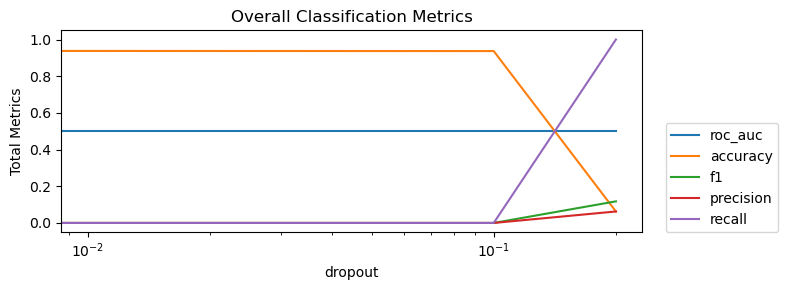

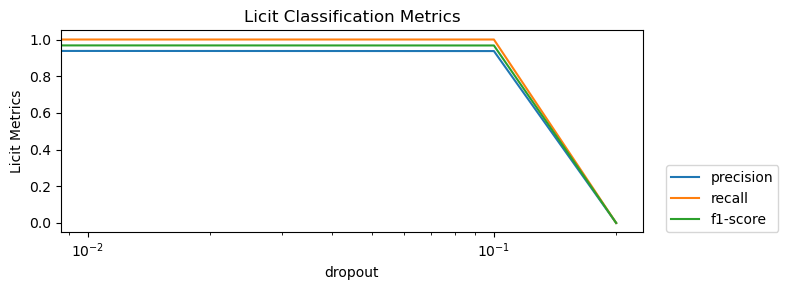

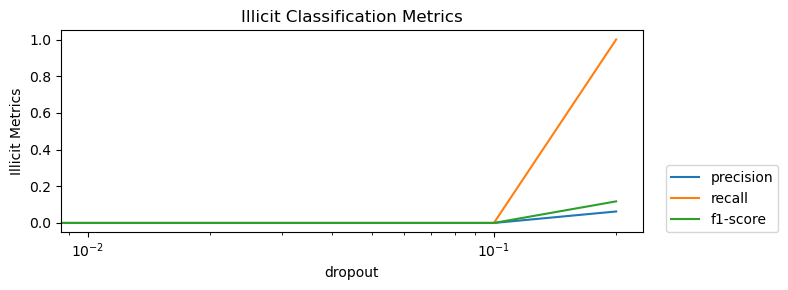

In [11]:
plot_metrics(metrics, para_list, para_change, x_log=True)

### Number of neighbors


In [12]:
metrics = create_metrics()
para_change = "num_neigh"
para_list = [[5, 5], [10, 10], [15, 15], [20, 20]]

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

Running num_neigh = [5, 5]
training with focal loss on GCN model


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:17<02:33, 17.04s/it]

Avg Batch Loss: 3.208e+10, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:30<01:59, 14.99s/it]

Avg Batch Loss: 3.046e+06, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:43<01:37, 13.96s/it]

Avg Batch Loss: 1.478e-01, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:56<01:22, 13.77s/it]

Avg Batch Loss: 1.491e-01, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [01:10<01:08, 13.76s/it]

Avg Batch Loss: 1.443e-01, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [01:23<00:54, 13.61s/it]

Avg Batch Loss: 1.351e-01, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [01:37<00:41, 13.78s/it]

Avg Batch Loss: 1.303e-01, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [01:52<00:27, 13.89s/it]

Avg Batch Loss: 1.290e-01, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [02:05<00:13, 13.69s/it]

Avg Batch Loss: 1.302e-01, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [02:19<00:00, 13.93s/it]

Avg Batch Loss: 1.317e-01, 


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:03<00:00,  1.95s/it]



Test Metrics:
Accuracy: 0.937
F1: 0.000
Precision: 0.000
Recall: 0.000

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     16438
           1       0.00      0.00      0.00      1104

    accuracy                           0.94     17542
   macro avg       0.47      0.50      0.48     17542
weighted avg       0.88      0.94      0.91     17542

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.5, 'accuracy': 0.937065328924866, 'f1': 0.0, 'precision': 0.0, 'recall': 0.0, 'classification_report': {'0': {'precision': 0.937065328924866, 'recall': 1.0, 'f1-score': 0.9675103001765745, 'support': 16438.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1104.0}, 'accuracy': 0.937065328924866, 'macro avg': {'precision': 0.468532664462433, 'recall': 0.5, 'f1-score': 0.48375515008828723, 'support': 17542.0}, 'weighted avg': {'precision': 0.8780914306730674, 'recall': 0.93706532892486

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:14<02:10, 14.48s/it]

Avg Batch Loss: 3.907e+10, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:28<01:52, 14.02s/it]

Avg Batch Loss: 2.015e+06, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:41<01:35, 13.59s/it]

Avg Batch Loss: 5.251e+05, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:54<01:20, 13.46s/it]

Avg Batch Loss: 1.920e+02, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [01:08<01:09, 13.83s/it]

Avg Batch Loss: 3.240e-01, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [01:24<00:57, 14.36s/it]

Avg Batch Loss: 1.634e-01, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [01:38<00:42, 14.33s/it]

Avg Batch Loss: 1.433e-01, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [01:53<00:28, 14.47s/it]

Avg Batch Loss: 1.299e-01, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [02:07<00:14, 14.31s/it]

Avg Batch Loss: 1.288e-01, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [02:21<00:00, 14.14s/it]

Avg Batch Loss: 1.288e-01, 


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]



Test Metrics:
Accuracy: 0.063
F1: 0.118
Precision: 0.063
Recall: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00     16392
           1       0.06      1.00      0.12      1101

    accuracy                           0.06     17493
   macro avg       0.53      0.50      0.06     17493
weighted avg       0.94      0.06      0.01     17493

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.5002135187896535, 'accuracy': 0.06333962156291088, 'f1': 0.11846989831602733, 'precision': 0.06296465744023791, 'recall': 1.0, 'classification_report': {'0': {'precision': 1.0, 'recall': 0.000427037579306979, 'f1-score': 0.000853710592109275, 'support': 16392.0}, '1': {'precision': 0.06296465744023791, 'recall': 1.0, 'f1-score': 0.11846989831602733, 'support': 1101.0}, 'accuracy': 0.06333962156291088, 'macro avg': {'precision': 0.5314823287201189, 'recall': 0.5002135187896535, 'f1-score': 0.059661804454

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:13<02:05, 13.99s/it]

Avg Batch Loss: 4.045e+07, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:29<01:59, 14.92s/it]

Avg Batch Loss: 4.948e+08, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:44<01:43, 14.84s/it]

Avg Batch Loss: 1.018e+05, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:58<01:27, 14.57s/it]

Avg Batch Loss: 7.449e+04, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [01:14<01:15, 15.10s/it]

Avg Batch Loss: 2.435e+04, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [01:29<00:59, 14.93s/it]

Avg Batch Loss: 8.370e+03, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [01:43<00:43, 14.64s/it]

Avg Batch Loss: 1.207e+04, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [01:57<00:28, 14.49s/it]

Avg Batch Loss: 1.828e+03, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [02:12<00:14, 14.79s/it]

Avg Batch Loss: 7.346e+02, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [02:28<00:00, 14.86s/it]

Avg Batch Loss: 1.252e+03, 


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:04<00:00,  2.15s/it]



Test Metrics:
Accuracy: 0.062
F1: 0.117
Precision: 0.062
Recall: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     16633
           1       0.06      1.00      0.12      1097

    accuracy                           0.06     17730
   macro avg       0.03      0.50      0.06     17730
weighted avg       0.00      0.06      0.01     17730

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.5, 'accuracy': 0.06187253243090807, 'f1': 0.1165347639029054, 'precision': 0.06187253243090807, 'recall': 1.0, 'classification_report': {'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 16633.0}, '1': {'precision': 0.06187253243090807, 'recall': 1.0, 'f1-score': 0.1165347639029054, 'support': 1097.0}, 'accuracy': 0.06187253243090807, 'macro avg': {'precision': 0.030936266215454034, 'recall': 0.5, 'f1-score': 0.0582673819514527, 'support': 17730.0}, 'weighted avg': {'precision': 0.00382

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:15<02:22, 15.84s/it]

Avg Batch Loss: 2.761e+10, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:31<02:04, 15.57s/it]

Avg Batch Loss: 5.626e+06, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:46<01:48, 15.57s/it]

Avg Batch Loss: 2.392e+07, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [01:03<01:36, 16.13s/it]

Avg Batch Loss: 3.328e+06, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [01:19<01:20, 16.02s/it]

Avg Batch Loss: 5.446e+05, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [01:34<01:02, 15.57s/it]

Avg Batch Loss: 2.009e+05, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [01:49<00:46, 15.47s/it]

Avg Batch Loss: 2.495e+04, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [02:04<00:30, 15.24s/it]

Avg Batch Loss: 1.120e+03, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [02:19<00:15, 15.16s/it]

Avg Batch Loss: 1.955e+02, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [02:33<00:00, 15.37s/it]

Avg Batch Loss: 7.733e+02, 


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:03<00:00,  1.84s/it]


Test Metrics:
Accuracy: 0.938
F1: 0.000
Precision: 0.000
Recall: 0.000

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     16675
           1       0.00      0.00      0.00      1107

    accuracy                           0.94     17782
   macro avg       0.47      0.50      0.48     17782
weighted avg       0.88      0.94      0.91     17782

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.5, 'accuracy': 0.9377460353166123, 'f1': 0.0, 'precision': 0.0, 'recall': 0.0, 'classification_report': {'0': {'precision': 0.9377460353166123, 'recall': 1.0, 'f1-score': 0.9678730011318455, 'support': 16675.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1107.0}, 'accuracy': 0.9377460353166123, 'macro avg': {'precision': 0.46887301765830613, 'recall': 0.5, 'f1-score': 0.48393650056592274, 'support': 17782.0}, 'weighted avg': {'precision': 0.8793676267520251, 'recall': 0.937746035

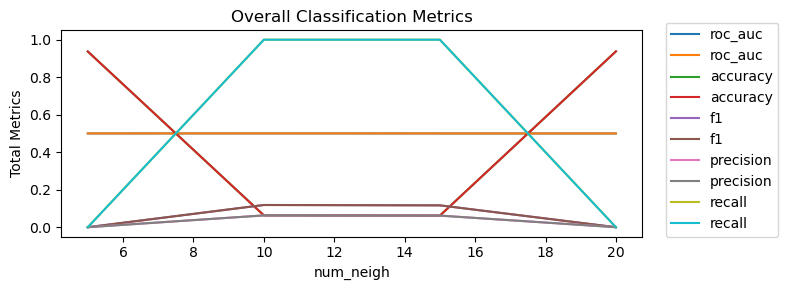

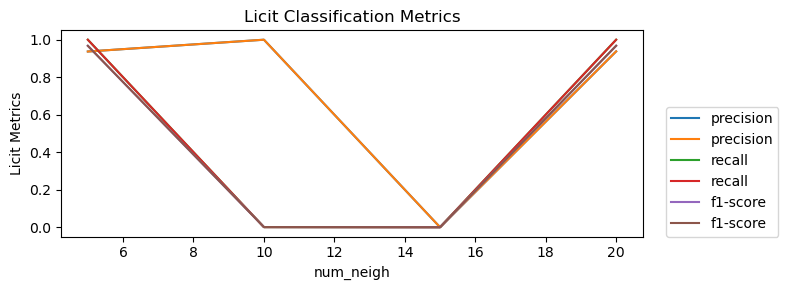

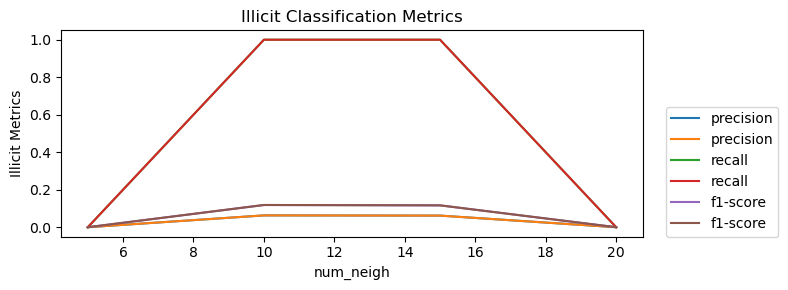

In [13]:
plot_metrics(metrics, para_list, para_change, x_log=False)

In [14]:
metrics = create_metrics()
para_change = "gamma"
para_list = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

metrics = hyperparameter_loop("loss", para_change, para_list, metrics)

Running gamma = 0.5
training with focal loss on GCN model


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:14<02:13, 14.80s/it]

Avg Batch Loss: 1.124e+11, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:27<01:49, 13.72s/it]

Avg Batch Loss: nan, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:40<01:32, 13.28s/it]

Avg Batch Loss: nan, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:53<01:18, 13.06s/it]

Avg Batch Loss: nan, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [01:06<01:04, 12.95s/it]

Avg Batch Loss: nan, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [01:18<00:51, 12.85s/it]

Avg Batch Loss: nan, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [01:31<00:38, 12.80s/it]

Avg Batch Loss: nan, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [01:43<00:25, 12.74s/it]

Avg Batch Loss: nan, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [01:56<00:12, 12.68s/it]

Avg Batch Loss: nan, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [02:09<00:00, 12.94s/it]

Avg Batch Loss: nan, 


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:03<00:00,  1.68s/it]



Test Metrics:
Accuracy: 0.938
F1: 0.000
Precision: 0.000
Recall: 0.000

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     16620
           1       0.00      0.00      0.00      1108

    accuracy                           0.94     17728
   macro avg       0.47      0.50      0.48     17728
weighted avg       0.88      0.94      0.91     17728

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.5, 'accuracy': 0.9375, 'f1': 0.0, 'precision': 0.0, 'recall': 0.0, 'classification_report': {'0': {'precision': 0.9375, 'recall': 1.0, 'f1-score': 0.967741935483871, 'support': 16620.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1108.0}, 'accuracy': 0.9375, 'macro avg': {'precision': 0.46875, 'recall': 0.5, 'f1-score': 0.4838709677419355, 'support': 17728.0}, 'weighted avg': {'precision': 0.87890625, 'recall': 0.9375, 'f1-score': 0.907258064516129, 'support': 17728.0}}}
Running 

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:14<02:09, 14.35s/it]

Avg Batch Loss: 4.329e+10, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:30<02:04, 15.54s/it]

Avg Batch Loss: 2.378e+06, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:45<01:46, 15.15s/it]

Avg Batch Loss: 5.639e+00, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [01:02<01:34, 15.80s/it]

Avg Batch Loss: 1.630e-01, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [01:18<01:19, 15.92s/it]

Avg Batch Loss: 1.888e+02, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [01:34<01:03, 15.94s/it]

Avg Batch Loss: 3.980e+05, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [01:49<00:47, 15.72s/it]

Avg Batch Loss: 2.514e+02, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [02:04<00:31, 15.54s/it]

Avg Batch Loss: 1.648e+04, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [02:20<00:15, 15.54s/it]

Avg Batch Loss: 1.375e-01, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [02:35<00:00, 15.52s/it]

Avg Batch Loss: 1.315e-01, 


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:03<00:00,  1.90s/it]



Test Metrics:
Accuracy: 0.083
F1: 0.120
Precision: 0.064
Recall: 0.992

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.02      0.04     16623
           1       0.06      0.99      0.12      1117

    accuracy                           0.08     17740
   macro avg       0.52      0.51      0.08     17740
weighted avg       0.92      0.08      0.05     17740

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.5069501161979032, 'accuracy': 0.08303269447576099, 'f1': 0.11989395660877564, 'precision': 0.06380283312219279, 'recall': 0.9919427036705462, 'classification_report': {'0': {'precision': 0.9759358288770054, 'recall': 0.021957528725260182, 'f1-score': 0.042948755662764015, 'support': 16623.0}, '1': {'precision': 0.06380283312219279, 'recall': 0.9919427036705462, 'f1-score': 0.11989395660877564, 'support': 1117.0}, 'accuracy': 0.08303269447576099, 'macro avg': {'precision': 0.5198693309995991, 'recall': 0

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:15<02:18, 15.35s/it]

Avg Batch Loss: 1.108e+10, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:30<02:00, 15.10s/it]

Avg Batch Loss: 1.385e+08, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:45<01:45, 15.05s/it]

Avg Batch Loss: 1.417e+08, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [01:01<01:33, 15.58s/it]

Avg Batch Loss: 1.057e+08, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [01:16<01:17, 15.49s/it]

Avg Batch Loss: 1.057e+08, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [01:32<01:02, 15.54s/it]

Avg Batch Loss: 5.564e+06, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [01:48<00:46, 15.50s/it]

Avg Batch Loss: 5.615e+06, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [02:03<00:30, 15.34s/it]

Avg Batch Loss: 2.780e+07, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [02:17<00:15, 15.19s/it]

Avg Batch Loss: 6.824e+06, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [02:32<00:00, 15.29s/it]

Avg Batch Loss: 3.848e+06, 


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:03<00:00,  1.84s/it]



Test Metrics:
Accuracy: 0.938
F1: 0.000
Precision: 0.000
Recall: 0.000

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     16718
           1       0.00      0.00      0.00      1114

    accuracy                           0.94     17832
   macro avg       0.47      0.50      0.48     17832
weighted avg       0.88      0.94      0.91     17832

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.5, 'accuracy': 0.9375280394795873, 'f1': 0.0, 'precision': 0.0, 'recall': 0.0, 'classification_report': {'0': {'precision': 0.9375280394795873, 'recall': 1.0, 'f1-score': 0.9677568740955137, 'support': 16718.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1114.0}, 'accuracy': 0.9375280394795873, 'macro avg': {'precision': 0.46876401973979365, 'recall': 0.5, 'f1-score': 0.48387843704775685, 'support': 17832.0}, 'weighted avg': {'precision': 0.8789588248104386, 'recall': 0.937528039

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:14<02:13, 14.86s/it]

Avg Batch Loss: 6.230e+10, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:29<01:56, 14.61s/it]

Avg Batch Loss: 3.149e+07, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:43<01:42, 14.65s/it]

Avg Batch Loss: 6.194e+06, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:58<01:28, 14.76s/it]

Avg Batch Loss: 9.850e+05, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [01:14<01:14, 14.93s/it]

Avg Batch Loss: 2.211e+06, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [01:29<01:00, 15.20s/it]

Avg Batch Loss: 1.524e+06, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [01:44<00:45, 15.17s/it]

Avg Batch Loss: 7.175e+05, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [01:59<00:30, 15.09s/it]

Avg Batch Loss: 1.476e+05, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [02:14<00:15, 15.04s/it]

Avg Batch Loss: 1.050e+05, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [02:31<00:00, 15.19s/it]

Avg Batch Loss: 3.764e+03, 


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:04<00:00,  2.16s/it]



Test Metrics:
Accuracy: 0.937
F1: 0.000
Precision: 0.000
Recall: 0.000

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     16584
           1       0.00      0.00      0.00      1121

    accuracy                           0.94     17705
   macro avg       0.47      0.50      0.48     17705
weighted avg       0.88      0.94      0.91     17705

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.5, 'accuracy': 0.9366845523863315, 'f1': 0.0, 'precision': 0.0, 'recall': 0.0, 'classification_report': {'0': {'precision': 0.9366845523863315, 'recall': 1.0, 'f1-score': 0.9673072997171105, 'support': 16584.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1121.0}, 'accuracy': 0.9366845523863315, 'macro avg': {'precision': 0.46834227619316576, 'recall': 0.5, 'f1-score': 0.48365364985855525, 'support': 17705.0}, 'weighted avg': {'precision': 0.8773779506791822, 'recall': 0.936684552

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:15<02:15, 15.09s/it]

Avg Batch Loss: 1.956e+10, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:29<01:56, 14.61s/it]

Avg Batch Loss: 3.936e+06, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:43<01:41, 14.50s/it]

Avg Batch Loss: 4.292e+06, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:58<01:27, 14.60s/it]

Avg Batch Loss: 2.269e+06, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [01:13<01:13, 14.67s/it]

Avg Batch Loss: 8.272e+05, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [01:28<00:58, 14.73s/it]

Avg Batch Loss: 8.033e+04, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [01:42<00:44, 14.68s/it]

Avg Batch Loss: 7.602e+04, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [01:57<00:29, 14.58s/it]

Avg Batch Loss: 7.329e+04, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [02:11<00:14, 14.56s/it]

Avg Batch Loss: 2.828e+04, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [02:25<00:00, 14.59s/it]

Avg Batch Loss: 1.346e+05, 


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:03<00:00,  1.82s/it]



Test Metrics:
Accuracy: 0.937
F1: 0.000
Precision: 0.000
Recall: 0.000

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     16606
           1       0.00      0.00      0.00      1110

    accuracy                           0.94     17716
   macro avg       0.47      0.50      0.48     17716
weighted avg       0.88      0.94      0.91     17716

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.5, 'accuracy': 0.9373447730864755, 'f1': 0.0, 'precision': 0.0, 'recall': 0.0, 'classification_report': {'0': {'precision': 0.9373447730864755, 'recall': 1.0, 'f1-score': 0.9676592273177553, 'support': 16606.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1110.0}, 'accuracy': 0.9373447730864755, 'macro avg': {'precision': 0.46867238654323773, 'recall': 0.5, 'f1-score': 0.48382961365887767, 'support': 17716.0}, 'weighted avg': {'precision': 0.8786152236325363, 'recall': 0.937344773

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:16<02:24, 16.01s/it]

Avg Batch Loss: 2.644e+09, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:30<02:02, 15.31s/it]

Avg Batch Loss: 1.989e+07, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:44<01:43, 14.74s/it]

Avg Batch Loss: 9.853e+05, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:58<01:25, 14.32s/it]

Avg Batch Loss: 3.764e+05, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [01:13<01:11, 14.39s/it]

Avg Batch Loss: 7.197e+05, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [01:27<00:57, 14.48s/it]

Avg Batch Loss: 2.369e+05, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [01:41<00:43, 14.35s/it]

Avg Batch Loss: 3.413e+05, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [01:55<00:28, 14.27s/it]

Avg Batch Loss: 1.019e+05, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [02:10<00:14, 14.22s/it]

Avg Batch Loss: 9.168e+04, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [02:24<00:00, 14.42s/it]

Avg Batch Loss: 4.166e+04, 


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:03<00:00,  1.80s/it]


Test Metrics:
Accuracy: 0.543
F1: 0.181
Precision: 0.102
Recall: 0.815

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.53      0.68     16706
           1       0.10      0.82      0.18      1104

    accuracy                           0.54     17810
   macro avg       0.54      0.67      0.43     17810
weighted avg       0.92      0.54      0.65     17810

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.6701491002972115, 'accuracy': 0.5430656934306569, 'f1': 0.18112296236667338, 'precision': 0.10187910346388952, 'recall': 0.8152173913043478, 'classification_report': {'0': {'precision': 0.9772727272727273, 'recall': 0.5250808092900754, 'f1-score': 0.6831243672611167, 'support': 16706.0}, '1': {'precision': 0.10187910346388952, 'recall': 0.8152173913043478, 'f1-score': 0.18112296236667338, 'support': 1104.0}, 'accuracy': 0.5430656934306569, 'macro avg': {'precision': 0.5395759153683084, 'recall': 0.67014

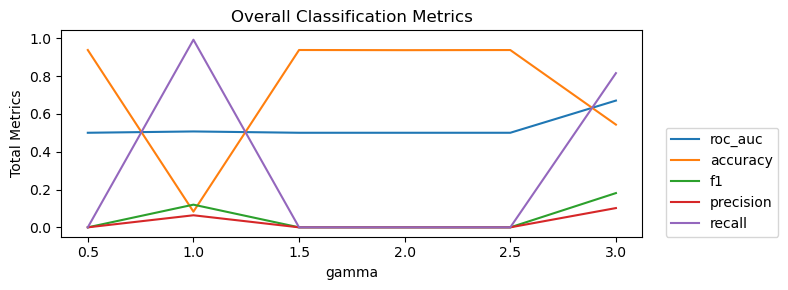

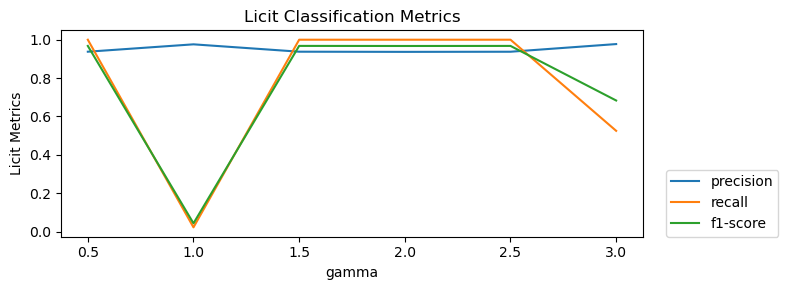

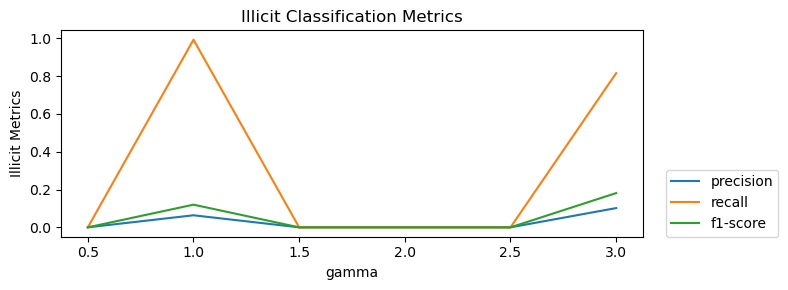

In [15]:
plot_metrics(metrics, para_list, para_change, x_log=False)

In [16]:
metrics = create_metrics()
para_change = "beta"
para_list = [0.9, 0.99, 0.999, 0.9999]

metrics = hyperparameter_loop("loss", para_change, para_list, metrics)

Running beta = 0.9
training with focal loss on GCN model


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:14<02:14, 14.92s/it]

Avg Batch Loss: 5.880e+10, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:29<01:58, 14.80s/it]

Avg Batch Loss: 8.709e+05, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:44<01:44, 14.86s/it]

Avg Batch Loss: 2.781e-01, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [01:00<01:30, 15.16s/it]

Avg Batch Loss: 5.561e-02, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [01:15<01:16, 15.28s/it]

Avg Batch Loss: 5.836e-02, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [01:30<01:01, 15.28s/it]

Avg Batch Loss: 6.285e+01, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [01:46<00:45, 15.26s/it]

Avg Batch Loss: 5.686e-02, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [02:01<00:30, 15.27s/it]

Avg Batch Loss: 1.651e+00, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [02:17<00:15, 15.37s/it]

Avg Batch Loss: 5.203e-02, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [02:32<00:00, 15.26s/it]

Avg Batch Loss: 5.339e-02, 


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:04<00:00,  2.49s/it]



Test Metrics:
Accuracy: 0.919
F1: 0.012
Precision: 0.026
Recall: 0.008

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     16673
           1       0.03      0.01      0.01      1114

    accuracy                           0.92     17787
   macro avg       0.48      0.49      0.49     17787
weighted avg       0.88      0.92      0.90     17787

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.49396332625200273, 'accuracy': 0.9189857761286333, 'f1': 0.01233721727210418, 'precision': 0.02608695652173913, 'recall': 0.00807899461400359, 'classification_report': {'0': {'precision': 0.9366471734892787, 'recall': 0.9798476578900018, 'f1-score': 0.9577605159020959, 'support': 16673.0}, '1': {'precision': 0.02608695652173913, 'recall': 0.00807899461400359, 'f1-score': 0.01233721727210418, 'support': 1114.0}, 'accuracy': 0.9189857761286333, 'macro avg': {'precision': 0.4813670650055089, 'recall': 0.49

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:15<02:16, 15.12s/it]

Avg Batch Loss: 4.570e+10, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:30<02:00, 15.09s/it]

Avg Batch Loss: 4.091e+05, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:45<01:46, 15.20s/it]

Avg Batch Loss: 6.022e-02, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [01:00<01:29, 14.96s/it]

Avg Batch Loss: 9.358e-02, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [01:14<01:14, 14.82s/it]

Avg Batch Loss: 7.013e-02, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [01:29<00:59, 14.82s/it]

Avg Batch Loss: 5.431e-02, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [01:45<00:45, 15.23s/it]

Avg Batch Loss: 1.173e-01, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [02:02<00:31, 15.62s/it]

Avg Batch Loss: 9.339e-02, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [02:18<00:15, 15.94s/it]

Avg Batch Loss: 6.032e-02, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [02:34<00:00, 15.41s/it]

Avg Batch Loss: 5.864e-02, 


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]



Test Metrics:
Accuracy: 0.937
F1: 0.000
Precision: 0.000
Recall: 0.000

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     16672
           1       0.00      0.00      0.00      1121

    accuracy                           0.94     17793
   macro avg       0.47      0.50      0.48     17793
weighted avg       0.88      0.94      0.91     17793

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.5, 'accuracy': 0.9369976957230371, 'f1': 0.0, 'precision': 0.0, 'recall': 0.0, 'classification_report': {'0': {'precision': 0.9369976957230371, 'recall': 1.0, 'f1-score': 0.9674742492383578, 'support': 16672.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1121.0}, 'accuracy': 0.9369976957230371, 'macro avg': {'precision': 0.4684988478615186, 'recall': 0.5, 'f1-score': 0.4837371246191789, 'support': 17793.0}, 'weighted avg': {'precision': 0.8779646817902813, 'recall': 0.93699769572

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:16<02:31, 16.85s/it]

Avg Batch Loss: 4.062e+10, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:33<02:11, 16.47s/it]

Avg Batch Loss: 3.538e+05, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:49<01:54, 16.33s/it]

Avg Batch Loss: 4.193e-01, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [01:04<01:34, 15.82s/it]

Avg Batch Loss: 6.396e-02, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [01:18<01:16, 15.35s/it]

Avg Batch Loss: 7.102e-02, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [01:33<01:01, 15.25s/it]

Avg Batch Loss: 1.152e-01, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [01:49<00:46, 15.37s/it]

Avg Batch Loss: 5.797e-02, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [02:07<00:32, 16.28s/it]

Avg Batch Loss: 6.079e-02, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [02:23<00:16, 16.18s/it]

Avg Batch Loss: 6.350e-02, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [02:39<00:00, 15.94s/it]

Avg Batch Loss: 5.873e-02, 


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:03<00:00,  1.92s/it]



Test Metrics:
Accuracy: 0.937
F1: 0.000
Precision: 0.000
Recall: 0.000

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     16562
           1       0.00      0.00      0.00      1113

    accuracy                           0.94     17675
   macro avg       0.47      0.50      0.48     17675
weighted avg       0.88      0.94      0.91     17675

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.5, 'accuracy': 0.9370297029702971, 'f1': 0.0, 'precision': 0.0, 'recall': 0.0, 'classification_report': {'0': {'precision': 0.9370297029702971, 'recall': 1.0, 'f1-score': 0.9674913105704355, 'support': 16562.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1113.0}, 'accuracy': 0.9370297029702971, 'macro avg': {'precision': 0.46851485148514854, 'recall': 0.5, 'f1-score': 0.48374565528521773, 'support': 17675.0}, 'weighted avg': {'precision': 0.8780246642486031, 'recall': 0.937029702

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:15<02:18, 15.37s/it]

Avg Batch Loss: 6.754e+10, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:29<01:58, 14.85s/it]

Avg Batch Loss: 2.037e+07, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:45<01:45, 15.13s/it]

Avg Batch Loss: 7.289e+06, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [01:01<01:32, 15.43s/it]

Avg Batch Loss: 7.745e+05, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [01:16<01:16, 15.20s/it]

Avg Batch Loss: 3.065e+05, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [01:34<01:05, 16.43s/it]

Avg Batch Loss: 2.733e+05, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [01:54<00:52, 17.43s/it]

Avg Batch Loss: 2.157e+05, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [02:10<00:33, 16.91s/it]

Avg Batch Loss: 1.162e+05, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [02:24<00:16, 16.22s/it]

Avg Batch Loss: 4.904e+04, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [02:39<00:00, 15.97s/it]

Avg Batch Loss: 3.437e+04, 


Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json
Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:03<00:00,  1.84s/it]


Test Metrics:
Accuracy: 0.634
F1: 0.192
Precision: 0.111
Recall: 0.698

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.63      0.76     16669
           1       0.11      0.70      0.19      1104

    accuracy                           0.63     17773
   macro avg       0.54      0.66      0.48     17773
weighted avg       0.92      0.63      0.73     17773

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.6639607139783039, 'accuracy': 0.6338265908963033, 'f1': 0.1915527950310559, 'precision': 0.11099913619349266, 'recall': 0.6983695652173914, 'classification_report': {'0': {'precision': 0.969243557772236, 'recall': 0.6295518627392165, 'f1-score': 0.7633110270584812, 'support': 16669.0}, '1': {'precision': 0.11099913619349266, 'recall': 0.6983695652173914, 'f1-score': 0.1915527950310559, 'support': 1104.0}, 'accuracy': 0.6338265908963033, 'macro avg': {'precision': 0.5401213469828643, 'recall': 0.66396071

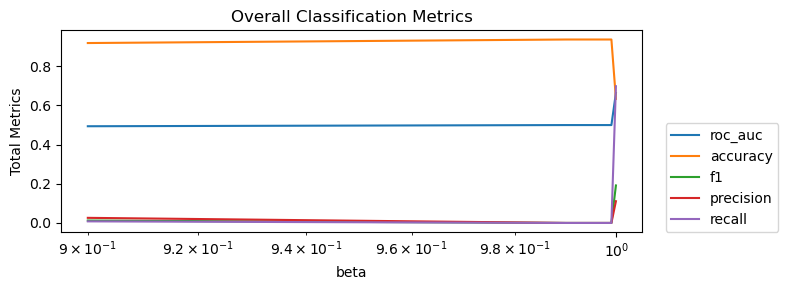

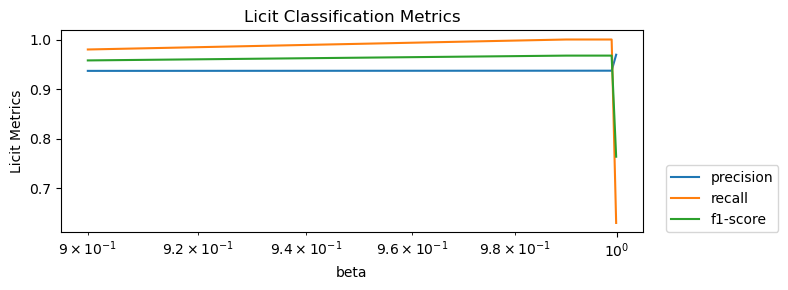

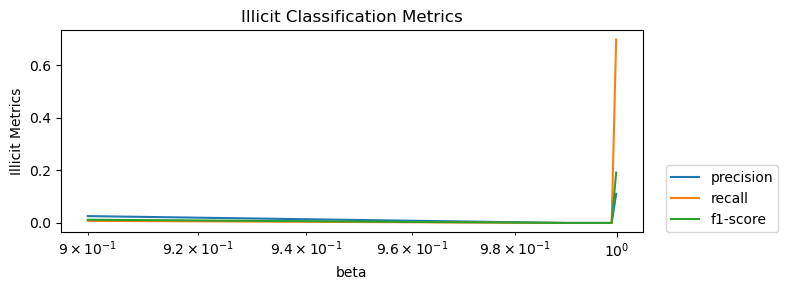

In [17]:
plot_metrics(metrics, para_list, para_change, x_log=True)

#### Epochs

In [6]:
config = {
        "model": {
            "hid_dim": 64,
            "num_layers": 2,
            "dropout": 0.2,
            "weight_decay": 0.0,
            "contamination": 0.1,
            # "backbone": "gcn",
            "lr": 0.01,
            "epoch": 10,
            "batch_size": 2048,
            "num_neigh": [10, 10],
            "weight": 0.5,
            "verbose": 1,
        },
        "data": {
            "data_root": "data/elliptic",
            "use_aggregated": False,
            "use_temporal": False,
            "batch_size": 16000
        },
        "loss": {
            "loss_type": "focal", # focal or ce
            "gamma": 1.0,
            "beta": 0.9999,
        },
        "training": {
            "save_embeddings": False,
            "save_dir": "./saved_models",
        },
        "classifiers": ["rf", "mlp"],
    }

In [7]:
metrics = create_metrics()
para_change = "epoch"
para_list = [10, 100, 200, 300] #200, 300

metrics = hyperparameter_loop("model", para_change, para_list, metrics)

Running epoch = 10
training with focal loss on GCN model


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


Epochs:  10%|█         | 1/10 [00:03<00:33,  3.76s/it]

Avg Batch Loss: 2.182e-01, 
Epoch 2/10


Epochs:  20%|██        | 2/10 [00:06<00:26,  3.28s/it]

Avg Batch Loss: 1.130e-01, 
Epoch 3/10


Epochs:  30%|███       | 3/10 [00:09<00:20,  2.97s/it]

Avg Batch Loss: 1.132e-01, 
Epoch 4/10


Epochs:  40%|████      | 4/10 [00:11<00:16,  2.77s/it]

Avg Batch Loss: 1.053e-01, 
Epoch 5/10


Epochs:  50%|█████     | 5/10 [00:14<00:13,  2.73s/it]

Avg Batch Loss: 9.020e-02, 
Epoch 6/10


Epochs:  60%|██████    | 6/10 [00:17<00:10,  2.73s/it]

Avg Batch Loss: 8.359e-02, 
Epoch 7/10


Epochs:  70%|███████   | 7/10 [00:19<00:07,  2.63s/it]

Avg Batch Loss: 7.706e-02, 
Epoch 8/10


Epochs:  80%|████████  | 8/10 [00:22<00:05,  2.58s/it]

Avg Batch Loss: 7.191e-02, 
Epoch 9/10


Epochs:  90%|█████████ | 9/10 [00:24<00:02,  2.56s/it]

Avg Batch Loss: 6.731e-02, 
Epoch 10/10


Epochs: 100%|██████████| 10/10 [00:27<00:00,  2.75s/it]

Avg Batch Loss: 6.434e-02, 
Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json


Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it]



Test Metrics:
Accuracy: 0.760
F1: 0.262
Precision: 0.162
Recall: 0.684

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.77      0.86     16540
           1       0.16      0.68      0.26      1098

    accuracy                           0.76     17638
   macro avg       0.57      0.72      0.56     17638
weighted avg       0.92      0.76      0.82     17638

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.7246335538067453, 'accuracy': 0.7602335865744415, 'f1': 0.26208340603734076, 'precision': 0.16209799266134253, 'recall': 0.6839708561020036, 'classification_report': {'0': {'precision': 0.9733179546328335, 'recall': 0.7652962515114873, 'f1-score': 0.8568624132678965, 'support': 16540.0}, '1': {'precision': 0.16209799266134253, 'recall': 0.6839708561020036, 'f1-score': 0.26208340603734076, 'support': 1098.0}, 'accuracy': 0.7602335865744415, 'macro avg': {'precision': 0.567707973647088, 'recall': 0.724633

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100


Epochs:   1%|          | 1/100 [00:02<04:17,  2.60s/it]

Avg Batch Loss: 1.712e-01, 
Epoch 2/100


Epochs:   2%|▏         | 2/100 [00:05<04:11,  2.56s/it]

Avg Batch Loss: 1.042e-01, 
Epoch 3/100


Epochs:   3%|▎         | 3/100 [00:07<04:07,  2.55s/it]

Avg Batch Loss: 1.017e-01, 
Epoch 4/100


Epochs:   4%|▍         | 4/100 [00:10<04:01,  2.51s/it]

Avg Batch Loss: 8.926e-02, 
Epoch 5/100


Epochs:   5%|▌         | 5/100 [00:12<04:08,  2.62s/it]

Avg Batch Loss: 8.032e-02, 
Epoch 6/100


Epochs:   6%|▌         | 6/100 [00:15<04:08,  2.65s/it]

Avg Batch Loss: 7.565e-02, 
Epoch 7/100


Epochs:   7%|▋         | 7/100 [00:18<03:59,  2.58s/it]

Avg Batch Loss: 6.785e-02, 
Epoch 8/100


Epochs:   8%|▊         | 8/100 [00:20<03:52,  2.53s/it]

Avg Batch Loss: 6.387e-02, 
Epoch 9/100


Epochs:   9%|▉         | 9/100 [00:22<03:46,  2.49s/it]

Avg Batch Loss: 6.200e-02, 
Epoch 10/100


Epochs:  10%|█         | 10/100 [00:25<03:42,  2.47s/it]

Avg Batch Loss: 6.013e-02, 
Epoch 11/100


Epochs:  11%|█         | 11/100 [00:27<03:37,  2.45s/it]

Avg Batch Loss: 5.789e-02, 
Epoch 12/100


Epochs:  12%|█▏        | 12/100 [00:30<03:39,  2.50s/it]

Avg Batch Loss: 5.537e-02, 
Epoch 13/100


Epochs:  13%|█▎        | 13/100 [00:32<03:40,  2.53s/it]

Avg Batch Loss: 5.399e-02, 
Epoch 14/100


Epochs:  14%|█▍        | 14/100 [00:35<03:37,  2.53s/it]

Avg Batch Loss: 5.334e-02, 
Epoch 15/100


Epochs:  15%|█▌        | 15/100 [00:38<03:35,  2.54s/it]

Avg Batch Loss: 5.198e-02, 
Epoch 16/100


Epochs:  16%|█▌        | 16/100 [00:40<03:30,  2.51s/it]

Avg Batch Loss: 4.933e-02, 
Epoch 17/100


Epochs:  17%|█▋        | 17/100 [00:42<03:28,  2.51s/it]

Avg Batch Loss: 4.934e-02, 
Epoch 18/100


Epochs:  18%|█▊        | 18/100 [00:45<03:28,  2.54s/it]

Avg Batch Loss: 4.821e-02, 
Epoch 19/100


Epochs:  19%|█▉        | 19/100 [00:48<03:28,  2.57s/it]

Avg Batch Loss: 4.645e-02, 
Epoch 20/100


Epochs:  20%|██        | 20/100 [00:50<03:24,  2.55s/it]

Avg Batch Loss: 4.650e-02, 
Epoch 21/100


Epochs:  21%|██        | 21/100 [00:53<03:20,  2.53s/it]

Avg Batch Loss: 4.612e-02, 
Epoch 22/100


Epochs:  22%|██▏       | 22/100 [00:55<03:15,  2.51s/it]

Avg Batch Loss: 4.497e-02, 
Epoch 23/100


Epochs:  23%|██▎       | 23/100 [00:58<03:16,  2.55s/it]

Avg Batch Loss: 4.472e-02, 
Epoch 24/100


Epochs:  24%|██▍       | 24/100 [01:01<03:18,  2.62s/it]

Avg Batch Loss: 4.366e-02, 
Epoch 25/100


Epochs:  25%|██▌       | 25/100 [01:03<03:12,  2.57s/it]

Avg Batch Loss: 4.255e-02, 
Epoch 26/100


Epochs:  26%|██▌       | 26/100 [01:05<03:05,  2.51s/it]

Avg Batch Loss: 4.241e-02, 
Epoch 27/100


Epochs:  27%|██▋       | 27/100 [01:08<03:05,  2.54s/it]

Avg Batch Loss: 4.254e-02, 
Epoch 28/100


Epochs:  28%|██▊       | 28/100 [01:11<03:05,  2.57s/it]

Avg Batch Loss: 4.139e-02, 
Epoch 29/100


Epochs:  29%|██▉       | 29/100 [01:13<03:01,  2.56s/it]

Avg Batch Loss: 4.073e-02, 
Epoch 30/100


Epochs:  30%|███       | 30/100 [01:16<03:02,  2.60s/it]

Avg Batch Loss: 3.948e-02, 
Epoch 31/100


Epochs:  31%|███       | 31/100 [01:18<02:56,  2.56s/it]

Avg Batch Loss: 3.978e-02, 
Epoch 32/100


Epochs:  32%|███▏      | 32/100 [01:21<02:52,  2.53s/it]

Avg Batch Loss: 4.126e-02, 
Epoch 33/100


Epochs:  33%|███▎      | 33/100 [01:23<02:47,  2.50s/it]

Avg Batch Loss: 3.928e-02, 
Epoch 34/100


Epochs:  34%|███▍      | 34/100 [01:26<02:44,  2.50s/it]

Avg Batch Loss: 3.915e-02, 
Epoch 35/100


Epochs:  35%|███▌      | 35/100 [01:28<02:40,  2.48s/it]

Avg Batch Loss: 3.882e-02, 
Epoch 36/100


Epochs:  36%|███▌      | 36/100 [01:31<02:38,  2.48s/it]

Avg Batch Loss: 3.841e-02, 
Epoch 37/100


Epochs:  37%|███▋      | 37/100 [01:34<02:43,  2.60s/it]

Avg Batch Loss: 3.871e-02, 
Epoch 38/100


Epochs:  38%|███▊      | 38/100 [01:36<02:40,  2.60s/it]

Avg Batch Loss: 3.716e-02, 
Epoch 39/100


Epochs:  39%|███▉      | 39/100 [01:39<02:38,  2.61s/it]

Avg Batch Loss: 3.643e-02, 
Epoch 40/100


Epochs:  40%|████      | 40/100 [01:41<02:34,  2.58s/it]

Avg Batch Loss: 3.688e-02, 
Epoch 41/100


Epochs:  41%|████      | 41/100 [01:44<02:31,  2.57s/it]

Avg Batch Loss: 3.619e-02, 
Epoch 42/100


Epochs:  42%|████▏     | 42/100 [01:46<02:28,  2.57s/it]

Avg Batch Loss: 3.563e-02, 
Epoch 43/100


Epochs:  43%|████▎     | 43/100 [01:49<02:26,  2.57s/it]

Avg Batch Loss: 3.542e-02, 
Epoch 44/100


Epochs:  44%|████▍     | 44/100 [01:51<02:22,  2.55s/it]

Avg Batch Loss: 3.601e-02, 
Epoch 45/100


Epochs:  45%|████▌     | 45/100 [01:54<02:19,  2.53s/it]

Avg Batch Loss: 3.527e-02, 
Epoch 46/100


Epochs:  46%|████▌     | 46/100 [01:57<02:18,  2.56s/it]

Avg Batch Loss: 3.440e-02, 
Epoch 47/100


Epochs:  47%|████▋     | 47/100 [01:59<02:14,  2.54s/it]

Avg Batch Loss: 3.480e-02, 
Epoch 48/100


Epochs:  48%|████▊     | 48/100 [02:02<02:11,  2.52s/it]

Avg Batch Loss: 3.450e-02, 
Epoch 49/100


Epochs:  49%|████▉     | 49/100 [02:04<02:08,  2.52s/it]

Avg Batch Loss: 3.428e-02, 
Epoch 50/100


Epochs:  50%|█████     | 50/100 [02:07<02:04,  2.49s/it]

Avg Batch Loss: 3.492e-02, 
Epoch 51/100


Epochs:  51%|█████     | 51/100 [02:09<02:03,  2.53s/it]

Avg Batch Loss: 3.395e-02, 
Epoch 52/100


Epochs:  52%|█████▏    | 52/100 [02:12<02:00,  2.51s/it]

Avg Batch Loss: 3.418e-02, 
Epoch 53/100


Epochs:  53%|█████▎    | 53/100 [02:14<01:57,  2.49s/it]

Avg Batch Loss: 3.313e-02, 
Epoch 54/100


Epochs:  54%|█████▍    | 54/100 [02:17<01:54,  2.48s/it]

Avg Batch Loss: 3.308e-02, 
Epoch 55/100


Epochs:  55%|█████▌    | 55/100 [02:19<01:52,  2.49s/it]

Avg Batch Loss: 3.266e-02, 
Epoch 56/100


Epochs:  56%|█████▌    | 56/100 [02:22<01:51,  2.52s/it]

Avg Batch Loss: 3.105e-02, 
Epoch 57/100


Epochs:  57%|█████▋    | 57/100 [02:24<01:49,  2.54s/it]

Avg Batch Loss: 3.246e-02, 
Epoch 58/100


Epochs:  58%|█████▊    | 58/100 [02:27<01:50,  2.64s/it]

Avg Batch Loss: 3.234e-02, 
Epoch 59/100


Epochs:  59%|█████▉    | 59/100 [02:30<01:51,  2.71s/it]

Avg Batch Loss: 3.212e-02, 
Epoch 60/100


Epochs:  60%|██████    | 60/100 [02:32<01:46,  2.66s/it]

Avg Batch Loss: 3.209e-02, 
Epoch 61/100


Epochs:  61%|██████    | 61/100 [02:35<01:41,  2.60s/it]

Avg Batch Loss: 3.187e-02, 
Epoch 62/100


Epochs:  62%|██████▏   | 62/100 [02:38<01:38,  2.60s/it]

Avg Batch Loss: 3.091e-02, 
Epoch 63/100


Epochs:  63%|██████▎   | 63/100 [02:40<01:37,  2.63s/it]

Avg Batch Loss: 3.172e-02, 
Epoch 64/100


Epochs:  64%|██████▍   | 64/100 [02:43<01:32,  2.58s/it]

Avg Batch Loss: 3.181e-02, 
Epoch 65/100


Epochs:  65%|██████▌   | 65/100 [02:45<01:30,  2.59s/it]

Avg Batch Loss: 3.109e-02, 
Epoch 66/100


Epochs:  66%|██████▌   | 66/100 [02:48<01:27,  2.58s/it]

Avg Batch Loss: 3.131e-02, 
Epoch 67/100


Epochs:  67%|██████▋   | 67/100 [02:50<01:24,  2.56s/it]

Avg Batch Loss: 3.072e-02, 
Epoch 68/100


Epochs:  68%|██████▊   | 68/100 [02:53<01:20,  2.53s/it]

Avg Batch Loss: 3.036e-02, 
Epoch 69/100


Epochs:  69%|██████▉   | 69/100 [02:55<01:17,  2.51s/it]

Avg Batch Loss: 3.008e-02, 
Epoch 70/100


Epochs:  70%|███████   | 70/100 [02:58<01:15,  2.53s/it]

Avg Batch Loss: 3.001e-02, 
Epoch 71/100


Epochs:  71%|███████   | 71/100 [03:00<01:12,  2.49s/it]

Avg Batch Loss: 3.079e-02, 
Epoch 72/100


Epochs:  72%|███████▏  | 72/100 [03:03<01:09,  2.49s/it]

Avg Batch Loss: 2.982e-02, 
Epoch 73/100


Epochs:  73%|███████▎  | 73/100 [03:05<01:07,  2.49s/it]

Avg Batch Loss: 2.963e-02, 
Epoch 74/100


Epochs:  74%|███████▍  | 74/100 [03:08<01:04,  2.48s/it]

Avg Batch Loss: 2.937e-02, 
Epoch 75/100


Epochs:  75%|███████▌  | 75/100 [03:10<01:01,  2.47s/it]

Avg Batch Loss: 2.978e-02, 
Epoch 76/100


Epochs:  76%|███████▌  | 76/100 [03:13<01:00,  2.51s/it]

Avg Batch Loss: 2.862e-02, 
Epoch 77/100


Epochs:  77%|███████▋  | 77/100 [03:15<00:56,  2.48s/it]

Avg Batch Loss: 2.882e-02, 
Epoch 78/100


Epochs:  78%|███████▊  | 78/100 [03:18<00:54,  2.47s/it]

Avg Batch Loss: 2.886e-02, 
Epoch 79/100


Epochs:  79%|███████▉  | 79/100 [03:20<00:52,  2.48s/it]

Avg Batch Loss: 2.878e-02, 
Epoch 80/100


Epochs:  80%|████████  | 80/100 [03:23<00:49,  2.47s/it]

Avg Batch Loss: 2.837e-02, 
Epoch 81/100


Epochs:  81%|████████  | 81/100 [03:25<00:47,  2.48s/it]

Avg Batch Loss: 2.872e-02, 
Epoch 82/100


Epochs:  82%|████████▏ | 82/100 [03:28<00:44,  2.50s/it]

Avg Batch Loss: 2.797e-02, 
Epoch 83/100


Epochs:  83%|████████▎ | 83/100 [03:30<00:42,  2.52s/it]

Avg Batch Loss: 2.832e-02, 
Epoch 84/100


Epochs:  84%|████████▍ | 84/100 [03:33<00:40,  2.50s/it]

Avg Batch Loss: 2.840e-02, 
Epoch 85/100


Epochs:  85%|████████▌ | 85/100 [03:35<00:37,  2.51s/it]

Avg Batch Loss: 2.877e-02, 
Epoch 86/100


Epochs:  86%|████████▌ | 86/100 [03:38<00:35,  2.52s/it]

Avg Batch Loss: 2.818e-02, 
Epoch 87/100


Epochs:  87%|████████▋ | 87/100 [03:41<00:34,  2.62s/it]

Avg Batch Loss: 2.801e-02, 
Epoch 88/100


Epochs:  88%|████████▊ | 88/100 [03:43<00:30,  2.58s/it]

Avg Batch Loss: 2.728e-02, 
Epoch 89/100


Epochs:  89%|████████▉ | 89/100 [03:46<00:27,  2.54s/it]

Avg Batch Loss: 2.746e-02, 
Epoch 90/100


Epochs:  90%|█████████ | 90/100 [03:48<00:25,  2.59s/it]

Avg Batch Loss: 2.746e-02, 
Epoch 91/100


Epochs:  91%|█████████ | 91/100 [03:51<00:23,  2.61s/it]

Avg Batch Loss: 2.731e-02, 
Epoch 92/100


Epochs:  92%|█████████▏| 92/100 [03:53<00:20,  2.59s/it]

Avg Batch Loss: 2.732e-02, 
Epoch 93/100


Epochs:  93%|█████████▎| 93/100 [03:56<00:17,  2.54s/it]

Avg Batch Loss: 2.809e-02, 
Epoch 94/100


Epochs:  94%|█████████▍| 94/100 [03:58<00:15,  2.54s/it]

Avg Batch Loss: 2.699e-02, 
Epoch 95/100


Epochs:  95%|█████████▌| 95/100 [04:01<00:12,  2.55s/it]

Avg Batch Loss: 2.654e-02, 
Epoch 96/100


Epochs:  96%|█████████▌| 96/100 [04:03<00:10,  2.52s/it]

Avg Batch Loss: 2.692e-02, 
Epoch 97/100


Epochs:  97%|█████████▋| 97/100 [04:06<00:07,  2.50s/it]

Avg Batch Loss: 2.602e-02, 
Epoch 98/100


Epochs:  98%|█████████▊| 98/100 [04:08<00:05,  2.50s/it]

Avg Batch Loss: 2.652e-02, 
Epoch 99/100


Epochs:  99%|█████████▉| 99/100 [04:11<00:02,  2.50s/it]

Avg Batch Loss: 2.643e-02, 
Epoch 100/100


Epochs: 100%|██████████| 100/100 [04:13<00:00,  2.54s/it]

Avg Batch Loss: 2.576e-02, 
Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json


Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it]



Test Metrics:
Accuracy: 0.929
F1: 0.452
Precision: 0.440
Recall: 0.464

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     16521
           1       0.44      0.46      0.45      1112

    accuracy                           0.93     17633
   macro avg       0.70      0.71      0.71     17633
weighted avg       0.93      0.93      0.93     17633

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.7121608687264824, 'accuracy': 0.928996767424715, 'f1': 0.45183887915936954, 'precision': 0.4402730375426621, 'recall': 0.46402877697841727, 'classification_report': {'0': {'precision': 0.9637932081890529, 'recall': 0.9602929604745476, 'f1-score': 0.9620399005518161, 'support': 16521.0}, '1': {'precision': 0.4402730375426621, 'recall': 0.46402877697841727, 'f1-score': 0.45183887915936954, 'support': 1112.0}, 'accuracy': 0.928996767424715, 'macro avg': {'precision': 0.7020331228658575, 'recall': 0.7121608

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200


Epochs:   0%|          | 1/200 [00:02<08:27,  2.55s/it]

Avg Batch Loss: 2.925e-01, 
Epoch 2/200


Epochs:   1%|          | 2/200 [00:05<08:18,  2.52s/it]

Avg Batch Loss: 1.274e-01, 
Epoch 3/200


Epochs:   2%|▏         | 3/200 [00:07<08:19,  2.54s/it]

Avg Batch Loss: 1.218e-01, 
Epoch 4/200


Epochs:   2%|▏         | 4/200 [00:10<08:23,  2.57s/it]

Avg Batch Loss: 1.155e-01, 
Epoch 5/200


Epochs:   2%|▎         | 5/200 [00:12<08:10,  2.52s/it]

Avg Batch Loss: 1.014e-01, 
Epoch 6/200


Epochs:   3%|▎         | 6/200 [00:15<08:00,  2.47s/it]

Avg Batch Loss: 9.404e-02, 
Epoch 7/200


Epochs:   4%|▎         | 7/200 [00:17<07:57,  2.48s/it]

Avg Batch Loss: 9.016e-02, 
Epoch 8/200


Epochs:   4%|▍         | 8/200 [00:20<08:04,  2.52s/it]

Avg Batch Loss: 8.271e-02, 
Epoch 9/200


Epochs:   4%|▍         | 9/200 [00:22<07:56,  2.50s/it]

Avg Batch Loss: 7.943e-02, 
Epoch 10/200


Epochs:   5%|▌         | 10/200 [00:25<07:54,  2.50s/it]

Avg Batch Loss: 7.118e-02, 
Epoch 11/200


Epochs:   6%|▌         | 11/200 [00:27<07:54,  2.51s/it]

Avg Batch Loss: 6.838e-02, 
Epoch 12/200


Epochs:   6%|▌         | 12/200 [00:30<07:48,  2.49s/it]

Avg Batch Loss: 6.519e-02, 
Epoch 13/200


Epochs:   6%|▋         | 13/200 [00:32<07:42,  2.47s/it]

Avg Batch Loss: 6.447e-02, 
Epoch 14/200


Epochs:   7%|▋         | 14/200 [00:34<07:37,  2.46s/it]

Avg Batch Loss: 6.112e-02, 
Epoch 15/200


Epochs:   8%|▊         | 15/200 [00:37<07:34,  2.45s/it]

Avg Batch Loss: 5.990e-02, 
Epoch 16/200


Epochs:   8%|▊         | 16/200 [00:40<07:47,  2.54s/it]

Avg Batch Loss: 5.731e-02, 
Epoch 17/200


Epochs:   8%|▊         | 17/200 [00:42<07:43,  2.53s/it]

Avg Batch Loss: 5.598e-02, 
Epoch 18/200


Epochs:   9%|▉         | 18/200 [00:45<07:41,  2.53s/it]

Avg Batch Loss: 5.475e-02, 
Epoch 19/200


Epochs:  10%|▉         | 19/200 [00:47<07:32,  2.50s/it]

Avg Batch Loss: 5.309e-02, 
Epoch 20/200


Epochs:  10%|█         | 20/200 [00:50<07:35,  2.53s/it]

Avg Batch Loss: 5.223e-02, 
Epoch 21/200


Epochs:  10%|█         | 21/200 [00:52<07:41,  2.58s/it]

Avg Batch Loss: 5.156e-02, 
Epoch 22/200


Epochs:  11%|█         | 22/200 [00:55<07:29,  2.53s/it]

Avg Batch Loss: 5.136e-02, 
Epoch 23/200


Epochs:  12%|█▏        | 23/200 [00:57<07:28,  2.54s/it]

Avg Batch Loss: 5.045e-02, 
Epoch 24/200


Epochs:  12%|█▏        | 24/200 [01:00<07:27,  2.54s/it]

Avg Batch Loss: 4.898e-02, 
Epoch 25/200


Epochs:  12%|█▎        | 25/200 [01:02<07:25,  2.55s/it]

Avg Batch Loss: 4.868e-02, 
Epoch 26/200


Epochs:  13%|█▎        | 26/200 [01:05<07:22,  2.54s/it]

Avg Batch Loss: 4.720e-02, 
Epoch 27/200


Epochs:  14%|█▎        | 27/200 [01:08<07:20,  2.55s/it]

Avg Batch Loss: 4.681e-02, 
Epoch 28/200


Epochs:  14%|█▍        | 28/200 [01:10<07:17,  2.55s/it]

Avg Batch Loss: 4.705e-02, 
Epoch 29/200


Epochs:  14%|█▍        | 29/200 [01:13<07:10,  2.52s/it]

Avg Batch Loss: 4.659e-02, 
Epoch 30/200


Epochs:  15%|█▌        | 30/200 [01:15<07:04,  2.50s/it]

Avg Batch Loss: 4.519e-02, 
Epoch 31/200


Epochs:  16%|█▌        | 31/200 [01:18<07:15,  2.58s/it]

Avg Batch Loss: 4.519e-02, 
Epoch 32/200


Epochs:  16%|█▌        | 32/200 [01:20<07:10,  2.56s/it]

Avg Batch Loss: 4.469e-02, 
Epoch 33/200


Epochs:  16%|█▋        | 33/200 [01:23<07:06,  2.55s/it]

Avg Batch Loss: 4.380e-02, 
Epoch 34/200


Epochs:  17%|█▋        | 34/200 [01:25<06:58,  2.52s/it]

Avg Batch Loss: 4.384e-02, 
Epoch 35/200


Epochs:  18%|█▊        | 35/200 [01:28<07:06,  2.59s/it]

Avg Batch Loss: 4.280e-02, 
Epoch 36/200


Epochs:  18%|█▊        | 36/200 [01:31<07:00,  2.56s/it]

Avg Batch Loss: 4.337e-02, 
Epoch 37/200


Epochs:  18%|█▊        | 37/200 [01:33<06:50,  2.52s/it]

Avg Batch Loss: 4.237e-02, 
Epoch 38/200


Epochs:  19%|█▉        | 38/200 [01:35<06:44,  2.50s/it]

Avg Batch Loss: 4.132e-02, 
Epoch 39/200


Epochs:  20%|█▉        | 39/200 [01:38<06:43,  2.51s/it]

Avg Batch Loss: 4.243e-02, 
Epoch 40/200


Epochs:  20%|██        | 40/200 [01:40<06:38,  2.49s/it]

Avg Batch Loss: 4.062e-02, 
Epoch 41/200


Epochs:  20%|██        | 41/200 [01:43<06:35,  2.49s/it]

Avg Batch Loss: 3.982e-02, 
Epoch 42/200


Epochs:  21%|██        | 42/200 [01:45<06:31,  2.48s/it]

Avg Batch Loss: 3.975e-02, 
Epoch 43/200


Epochs:  22%|██▏       | 43/200 [01:48<06:25,  2.46s/it]

Avg Batch Loss: 3.882e-02, 
Epoch 44/200


Epochs:  22%|██▏       | 44/200 [01:50<06:20,  2.44s/it]

Avg Batch Loss: 3.948e-02, 
Epoch 45/200


Epochs:  22%|██▎       | 45/200 [01:53<06:24,  2.48s/it]

Avg Batch Loss: 3.970e-02, 
Epoch 46/200


Epochs:  23%|██▎       | 46/200 [01:55<06:19,  2.46s/it]

Avg Batch Loss: 4.005e-02, 
Epoch 47/200


Epochs:  24%|██▎       | 47/200 [01:58<06:13,  2.44s/it]

Avg Batch Loss: 3.872e-02, 
Epoch 48/200


Epochs:  24%|██▍       | 48/200 [02:00<06:11,  2.45s/it]

Avg Batch Loss: 3.912e-02, 
Epoch 49/200


Epochs:  24%|██▍       | 49/200 [02:02<06:05,  2.42s/it]

Avg Batch Loss: 3.794e-02, 
Epoch 50/200


Epochs:  25%|██▌       | 50/200 [02:05<06:01,  2.41s/it]

Avg Batch Loss: 3.845e-02, 
Epoch 51/200


Epochs:  26%|██▌       | 51/200 [02:07<05:59,  2.41s/it]

Avg Batch Loss: 3.761e-02, 
Epoch 52/200


Epochs:  26%|██▌       | 52/200 [02:10<05:57,  2.41s/it]

Avg Batch Loss: 3.719e-02, 
Epoch 53/200


Epochs:  26%|██▋       | 53/200 [02:12<05:59,  2.44s/it]

Avg Batch Loss: 3.742e-02, 
Epoch 54/200


Epochs:  27%|██▋       | 54/200 [02:15<06:02,  2.48s/it]

Avg Batch Loss: 3.684e-02, 
Epoch 55/200


Epochs:  28%|██▊       | 55/200 [02:17<06:00,  2.49s/it]

Avg Batch Loss: 3.610e-02, 
Epoch 56/200


Epochs:  28%|██▊       | 56/200 [02:20<05:55,  2.47s/it]

Avg Batch Loss: 3.631e-02, 
Epoch 57/200


Epochs:  28%|██▊       | 57/200 [02:22<05:52,  2.47s/it]

Avg Batch Loss: 3.652e-02, 
Epoch 58/200


Epochs:  29%|██▉       | 58/200 [02:25<05:51,  2.48s/it]

Avg Batch Loss: 3.611e-02, 
Epoch 59/200


Epochs:  30%|██▉       | 59/200 [02:27<05:51,  2.49s/it]

Avg Batch Loss: 3.653e-02, 
Epoch 60/200


Epochs:  30%|███       | 60/200 [02:30<05:49,  2.50s/it]

Avg Batch Loss: 3.547e-02, 
Epoch 61/200


Epochs:  30%|███       | 61/200 [02:32<05:54,  2.55s/it]

Avg Batch Loss: 3.540e-02, 
Epoch 62/200


Epochs:  31%|███       | 62/200 [02:35<05:58,  2.60s/it]

Avg Batch Loss: 3.525e-02, 
Epoch 63/200


Epochs:  32%|███▏      | 63/200 [02:37<05:54,  2.59s/it]

Avg Batch Loss: 3.568e-02, 
Epoch 64/200


Epochs:  32%|███▏      | 64/200 [02:40<05:51,  2.58s/it]

Avg Batch Loss: 3.472e-02, 
Epoch 65/200


Epochs:  32%|███▎      | 65/200 [02:43<05:51,  2.60s/it]

Avg Batch Loss: 3.425e-02, 
Epoch 66/200


Epochs:  33%|███▎      | 66/200 [02:45<05:46,  2.58s/it]

Avg Batch Loss: 3.350e-02, 
Epoch 67/200


Epochs:  34%|███▎      | 67/200 [02:48<05:38,  2.55s/it]

Avg Batch Loss: 3.483e-02, 
Epoch 68/200


Epochs:  34%|███▍      | 68/200 [02:50<05:31,  2.51s/it]

Avg Batch Loss: 3.466e-02, 
Epoch 69/200


Epochs:  34%|███▍      | 69/200 [02:53<05:26,  2.49s/it]

Avg Batch Loss: 3.397e-02, 
Epoch 70/200


Epochs:  35%|███▌      | 70/200 [02:55<05:22,  2.48s/it]

Avg Batch Loss: 3.360e-02, 
Epoch 71/200


Epochs:  36%|███▌      | 71/200 [02:58<05:21,  2.49s/it]

Avg Batch Loss: 3.339e-02, 
Epoch 72/200


Epochs:  36%|███▌      | 72/200 [03:00<05:23,  2.53s/it]

Avg Batch Loss: 3.306e-02, 
Epoch 73/200


Epochs:  36%|███▋      | 73/200 [03:03<05:20,  2.52s/it]

Avg Batch Loss: 3.290e-02, 
Epoch 74/200


Epochs:  37%|███▋      | 74/200 [03:05<05:17,  2.52s/it]

Avg Batch Loss: 3.317e-02, 
Epoch 75/200


Epochs:  38%|███▊      | 75/200 [03:08<05:11,  2.49s/it]

Avg Batch Loss: 3.315e-02, 
Epoch 76/200


Epochs:  38%|███▊      | 76/200 [03:10<05:05,  2.46s/it]

Avg Batch Loss: 3.265e-02, 
Epoch 77/200


Epochs:  38%|███▊      | 77/200 [03:12<05:03,  2.47s/it]

Avg Batch Loss: 3.252e-02, 
Epoch 78/200


Epochs:  39%|███▉      | 78/200 [03:15<05:00,  2.46s/it]

Avg Batch Loss: 3.271e-02, 
Epoch 79/200


Epochs:  40%|███▉      | 79/200 [03:17<04:59,  2.47s/it]

Avg Batch Loss: 3.210e-02, 
Epoch 80/200


Epochs:  40%|████      | 80/200 [03:20<04:55,  2.46s/it]

Avg Batch Loss: 3.220e-02, 
Epoch 81/200


Epochs:  40%|████      | 81/200 [03:22<04:56,  2.50s/it]

Avg Batch Loss: 3.160e-02, 
Epoch 82/200


Epochs:  41%|████      | 82/200 [03:25<04:54,  2.50s/it]

Avg Batch Loss: 3.188e-02, 
Epoch 83/200


Epochs:  42%|████▏     | 83/200 [03:28<04:54,  2.52s/it]

Avg Batch Loss: 3.208e-02, 
Epoch 84/200


Epochs:  42%|████▏     | 84/200 [03:30<04:53,  2.53s/it]

Avg Batch Loss: 3.174e-02, 
Epoch 85/200


Epochs:  42%|████▎     | 85/200 [03:33<04:51,  2.54s/it]

Avg Batch Loss: 3.081e-02, 
Epoch 86/200


Epochs:  43%|████▎     | 86/200 [03:35<04:49,  2.54s/it]

Avg Batch Loss: 3.170e-02, 
Epoch 87/200


Epochs:  44%|████▎     | 87/200 [03:38<04:45,  2.53s/it]

Avg Batch Loss: 3.091e-02, 
Epoch 88/200


Epochs:  44%|████▍     | 88/200 [03:40<04:52,  2.61s/it]

Avg Batch Loss: 3.078e-02, 
Epoch 89/200


Epochs:  44%|████▍     | 89/200 [03:43<04:51,  2.63s/it]

Avg Batch Loss: 3.074e-02, 
Epoch 90/200


Epochs:  45%|████▌     | 90/200 [03:46<04:43,  2.58s/it]

Avg Batch Loss: 3.131e-02, 
Epoch 91/200


Epochs:  46%|████▌     | 91/200 [03:48<04:39,  2.56s/it]

Avg Batch Loss: 3.074e-02, 
Epoch 92/200


Epochs:  46%|████▌     | 92/200 [03:51<04:36,  2.56s/it]

Avg Batch Loss: 3.017e-02, 
Epoch 93/200


Epochs:  46%|████▋     | 93/200 [03:53<04:34,  2.57s/it]

Avg Batch Loss: 3.079e-02, 
Epoch 94/200


Epochs:  47%|████▋     | 94/200 [03:56<04:30,  2.55s/it]

Avg Batch Loss: 3.038e-02, 
Epoch 95/200


Epochs:  48%|████▊     | 95/200 [03:58<04:30,  2.58s/it]

Avg Batch Loss: 3.006e-02, 
Epoch 96/200


Epochs:  48%|████▊     | 96/200 [04:01<04:26,  2.56s/it]

Avg Batch Loss: 3.075e-02, 
Epoch 97/200


Epochs:  48%|████▊     | 97/200 [04:03<04:20,  2.53s/it]

Avg Batch Loss: 3.083e-02, 
Epoch 98/200


Epochs:  49%|████▉     | 98/200 [04:06<04:14,  2.49s/it]

Avg Batch Loss: 2.954e-02, 
Epoch 99/200


Epochs:  50%|████▉     | 99/200 [04:08<04:11,  2.49s/it]

Avg Batch Loss: 2.917e-02, 
Epoch 100/200


Epochs:  50%|█████     | 100/200 [04:11<04:07,  2.48s/it]

Avg Batch Loss: 2.950e-02, 
Epoch 101/200


Epochs:  50%|█████     | 101/200 [04:13<04:03,  2.46s/it]

Avg Batch Loss: 2.976e-02, 
Epoch 102/200


Epochs:  51%|█████     | 102/200 [04:16<04:05,  2.50s/it]

Avg Batch Loss: 2.928e-02, 
Epoch 103/200


Epochs:  52%|█████▏    | 103/200 [04:18<04:03,  2.51s/it]

Avg Batch Loss: 2.930e-02, 
Epoch 104/200


Epochs:  52%|█████▏    | 104/200 [04:21<03:57,  2.48s/it]

Avg Batch Loss: 2.951e-02, 
Epoch 105/200


Epochs:  52%|█████▎    | 105/200 [04:23<03:55,  2.48s/it]

Avg Batch Loss: 2.965e-02, 
Epoch 106/200


Epochs:  53%|█████▎    | 106/200 [04:26<03:54,  2.50s/it]

Avg Batch Loss: 3.026e-02, 
Epoch 107/200


Epochs:  54%|█████▎    | 107/200 [04:28<03:57,  2.56s/it]

Avg Batch Loss: 2.891e-02, 
Epoch 108/200


Epochs:  54%|█████▍    | 108/200 [04:31<03:55,  2.56s/it]

Avg Batch Loss: 2.867e-02, 
Epoch 109/200


Epochs:  55%|█████▍    | 109/200 [04:33<03:50,  2.54s/it]

Avg Batch Loss: 2.871e-02, 
Epoch 110/200


Epochs:  55%|█████▌    | 110/200 [04:36<03:49,  2.55s/it]

Avg Batch Loss: 2.953e-02, 
Epoch 111/200


Epochs:  56%|█████▌    | 111/200 [04:39<03:49,  2.58s/it]

Avg Batch Loss: 2.917e-02, 
Epoch 112/200


Epochs:  56%|█████▌    | 112/200 [04:41<03:45,  2.56s/it]

Avg Batch Loss: 2.891e-02, 
Epoch 113/200


Epochs:  56%|█████▋    | 113/200 [04:44<03:42,  2.55s/it]

Avg Batch Loss: 2.889e-02, 
Epoch 114/200


Epochs:  57%|█████▋    | 114/200 [04:46<03:36,  2.51s/it]

Avg Batch Loss: 2.788e-02, 
Epoch 115/200


Epochs:  57%|█████▊    | 115/200 [04:49<03:34,  2.52s/it]

Avg Batch Loss: 2.845e-02, 
Epoch 116/200


Epochs:  58%|█████▊    | 116/200 [04:51<03:31,  2.51s/it]

Avg Batch Loss: 2.785e-02, 
Epoch 117/200


Epochs:  58%|█████▊    | 117/200 [04:54<03:37,  2.62s/it]

Avg Batch Loss: 2.863e-02, 
Epoch 118/200


Epochs:  59%|█████▉    | 118/200 [04:57<03:33,  2.60s/it]

Avg Batch Loss: 2.842e-02, 
Epoch 119/200


Epochs:  60%|█████▉    | 119/200 [04:59<03:27,  2.56s/it]

Avg Batch Loss: 2.815e-02, 
Epoch 120/200


Epochs:  60%|██████    | 120/200 [05:01<03:20,  2.51s/it]

Avg Batch Loss: 2.770e-02, 
Epoch 121/200


Epochs:  60%|██████    | 121/200 [05:04<03:17,  2.50s/it]

Avg Batch Loss: 2.807e-02, 
Epoch 122/200


Epochs:  61%|██████    | 122/200 [05:06<03:12,  2.47s/it]

Avg Batch Loss: 2.781e-02, 
Epoch 123/200


Epochs:  62%|██████▏   | 123/200 [05:09<03:11,  2.48s/it]

Avg Batch Loss: 2.748e-02, 
Epoch 124/200


Epochs:  62%|██████▏   | 124/200 [05:11<03:07,  2.47s/it]

Avg Batch Loss: 2.771e-02, 
Epoch 125/200


Epochs:  62%|██████▎   | 125/200 [05:14<03:04,  2.46s/it]

Avg Batch Loss: 2.701e-02, 
Epoch 126/200


Epochs:  63%|██████▎   | 126/200 [05:16<03:01,  2.46s/it]

Avg Batch Loss: 2.727e-02, 
Epoch 127/200


Epochs:  64%|██████▎   | 127/200 [05:19<03:00,  2.47s/it]

Avg Batch Loss: 2.776e-02, 
Epoch 128/200


Epochs:  64%|██████▍   | 128/200 [05:21<02:59,  2.49s/it]

Avg Batch Loss: 2.707e-02, 
Epoch 129/200


Epochs:  64%|██████▍   | 129/200 [05:24<02:55,  2.47s/it]

Avg Batch Loss: 2.724e-02, 
Epoch 130/200


Epochs:  65%|██████▌   | 130/200 [05:26<02:51,  2.44s/it]

Avg Batch Loss: 2.671e-02, 
Epoch 131/200


Epochs:  66%|██████▌   | 131/200 [05:28<02:47,  2.43s/it]

Avg Batch Loss: 2.749e-02, 
Epoch 132/200


Epochs:  66%|██████▌   | 132/200 [05:31<02:46,  2.44s/it]

Avg Batch Loss: 2.724e-02, 
Epoch 133/200


Epochs:  66%|██████▋   | 133/200 [05:33<02:43,  2.44s/it]

Avg Batch Loss: 2.617e-02, 
Epoch 134/200


Epochs:  67%|██████▋   | 134/200 [05:36<02:40,  2.44s/it]

Avg Batch Loss: 2.658e-02, 
Epoch 135/200


Epochs:  68%|██████▊   | 135/200 [05:38<02:38,  2.43s/it]

Avg Batch Loss: 2.688e-02, 
Epoch 136/200


Epochs:  68%|██████▊   | 136/200 [05:41<02:36,  2.44s/it]

Avg Batch Loss: 2.610e-02, 
Epoch 137/200


Epochs:  68%|██████▊   | 137/200 [05:43<02:35,  2.46s/it]

Avg Batch Loss: 2.649e-02, 
Epoch 138/200


Epochs:  69%|██████▉   | 138/200 [05:46<02:32,  2.45s/it]

Avg Batch Loss: 2.588e-02, 
Epoch 139/200


Epochs:  70%|██████▉   | 139/200 [05:48<02:29,  2.45s/it]

Avg Batch Loss: 2.676e-02, 
Epoch 140/200


Epochs:  70%|███████   | 140/200 [05:51<02:27,  2.46s/it]

Avg Batch Loss: 2.656e-02, 
Epoch 141/200


Epochs:  70%|███████   | 141/200 [05:53<02:25,  2.46s/it]

Avg Batch Loss: 2.612e-02, 
Epoch 142/200


Epochs:  71%|███████   | 142/200 [05:55<02:22,  2.45s/it]

Avg Batch Loss: 2.544e-02, 
Epoch 143/200


Epochs:  72%|███████▏  | 143/200 [05:58<02:19,  2.45s/it]

Avg Batch Loss: 2.575e-02, 
Epoch 144/200


Epochs:  72%|███████▏  | 144/200 [06:00<02:18,  2.47s/it]

Avg Batch Loss: 2.618e-02, 
Epoch 145/200


Epochs:  72%|███████▎  | 145/200 [06:03<02:16,  2.48s/it]

Avg Batch Loss: 2.659e-02, 
Epoch 146/200


Epochs:  73%|███████▎  | 146/200 [06:05<02:14,  2.49s/it]

Avg Batch Loss: 2.561e-02, 
Epoch 147/200


Epochs:  74%|███████▎  | 147/200 [06:08<02:12,  2.49s/it]

Avg Batch Loss: 2.664e-02, 
Epoch 148/200


Epochs:  74%|███████▍  | 148/200 [06:10<02:08,  2.47s/it]

Avg Batch Loss: 2.603e-02, 
Epoch 149/200


Epochs:  74%|███████▍  | 149/200 [06:13<02:05,  2.45s/it]

Avg Batch Loss: 2.544e-02, 
Epoch 150/200


Epochs:  75%|███████▌  | 150/200 [06:15<02:03,  2.47s/it]

Avg Batch Loss: 2.596e-02, 
Epoch 151/200


Epochs:  76%|███████▌  | 151/200 [06:18<02:01,  2.47s/it]

Avg Batch Loss: 2.507e-02, 
Epoch 152/200


Epochs:  76%|███████▌  | 152/200 [06:20<02:01,  2.54s/it]

Avg Batch Loss: 2.506e-02, 
Epoch 153/200


Epochs:  76%|███████▋  | 153/200 [06:23<01:59,  2.54s/it]

Avg Batch Loss: 2.524e-02, 
Epoch 154/200


Epochs:  77%|███████▋  | 154/200 [06:25<01:56,  2.53s/it]

Avg Batch Loss: 2.578e-02, 
Epoch 155/200


Epochs:  78%|███████▊  | 155/200 [06:28<01:56,  2.59s/it]

Avg Batch Loss: 2.569e-02, 
Epoch 156/200


Epochs:  78%|███████▊  | 156/200 [06:31<01:53,  2.59s/it]

Avg Batch Loss: 2.497e-02, 
Epoch 157/200


Epochs:  78%|███████▊  | 157/200 [06:33<01:50,  2.57s/it]

Avg Batch Loss: 2.495e-02, 
Epoch 158/200


Epochs:  79%|███████▉  | 158/200 [06:36<01:47,  2.57s/it]

Avg Batch Loss: 2.467e-02, 
Epoch 159/200


Epochs:  80%|███████▉  | 159/200 [06:38<01:44,  2.55s/it]

Avg Batch Loss: 2.463e-02, 
Epoch 160/200


Epochs:  80%|████████  | 160/200 [06:41<01:42,  2.56s/it]

Avg Batch Loss: 2.503e-02, 
Epoch 161/200


Epochs:  80%|████████  | 161/200 [06:44<01:40,  2.57s/it]

Avg Batch Loss: 2.515e-02, 
Epoch 162/200


Epochs:  81%|████████  | 162/200 [06:46<01:36,  2.55s/it]

Avg Batch Loss: 2.421e-02, 
Epoch 163/200


Epochs:  82%|████████▏ | 163/200 [06:49<01:33,  2.53s/it]

Avg Batch Loss: 2.478e-02, 
Epoch 164/200


Epochs:  82%|████████▏ | 164/200 [06:51<01:30,  2.53s/it]

Avg Batch Loss: 2.432e-02, 
Epoch 165/200


Epochs:  82%|████████▎ | 165/200 [06:54<01:29,  2.54s/it]

Avg Batch Loss: 2.465e-02, 
Epoch 166/200


Epochs:  83%|████████▎ | 166/200 [06:56<01:26,  2.53s/it]

Avg Batch Loss: 2.486e-02, 
Epoch 167/200


Epochs:  84%|████████▎ | 167/200 [06:59<01:23,  2.54s/it]

Avg Batch Loss: 2.496e-02, 
Epoch 168/200


Epochs:  84%|████████▍ | 168/200 [07:01<01:21,  2.54s/it]

Avg Batch Loss: 2.392e-02, 
Epoch 169/200


Epochs:  84%|████████▍ | 169/200 [07:04<01:19,  2.57s/it]

Avg Batch Loss: 2.477e-02, 
Epoch 170/200


Epochs:  85%|████████▌ | 170/200 [07:07<01:24,  2.83s/it]

Avg Batch Loss: 2.449e-02, 
Epoch 171/200


Epochs:  86%|████████▌ | 171/200 [07:10<01:22,  2.83s/it]

Avg Batch Loss: 2.404e-02, 
Epoch 172/200


Epochs:  86%|████████▌ | 172/200 [07:13<01:18,  2.81s/it]

Avg Batch Loss: 2.434e-02, 
Epoch 173/200


Epochs:  86%|████████▋ | 173/200 [07:15<01:12,  2.70s/it]

Avg Batch Loss: 2.343e-02, 
Epoch 174/200


Epochs:  87%|████████▋ | 174/200 [07:18<01:08,  2.63s/it]

Avg Batch Loss: 2.408e-02, 
Epoch 175/200


Epochs:  88%|████████▊ | 175/200 [07:20<01:04,  2.57s/it]

Avg Batch Loss: 2.427e-02, 
Epoch 176/200


Epochs:  88%|████████▊ | 176/200 [07:23<01:00,  2.54s/it]

Avg Batch Loss: 2.419e-02, 
Epoch 177/200


Epochs:  88%|████████▊ | 177/200 [07:25<00:57,  2.50s/it]

Avg Batch Loss: 2.379e-02, 
Epoch 178/200


Epochs:  89%|████████▉ | 178/200 [07:28<00:54,  2.48s/it]

Avg Batch Loss: 2.375e-02, 
Epoch 179/200


Epochs:  90%|████████▉ | 179/200 [07:30<00:51,  2.46s/it]

Avg Batch Loss: 2.374e-02, 
Epoch 180/200


Epochs:  90%|█████████ | 180/200 [07:32<00:48,  2.45s/it]

Avg Batch Loss: 2.339e-02, 
Epoch 181/200


Epochs:  90%|█████████ | 181/200 [07:35<00:46,  2.45s/it]

Avg Batch Loss: 2.359e-02, 
Epoch 182/200


Epochs:  91%|█████████ | 182/200 [07:37<00:44,  2.46s/it]

Avg Batch Loss: 2.388e-02, 
Epoch 183/200


Epochs:  92%|█████████▏| 183/200 [07:40<00:41,  2.44s/it]

Avg Batch Loss: 2.384e-02, 
Epoch 184/200


Epochs:  92%|█████████▏| 184/200 [07:42<00:38,  2.43s/it]

Avg Batch Loss: 2.391e-02, 
Epoch 185/200


Epochs:  92%|█████████▎| 185/200 [07:45<00:36,  2.43s/it]

Avg Batch Loss: 2.373e-02, 
Epoch 186/200


Epochs:  93%|█████████▎| 186/200 [07:47<00:34,  2.43s/it]

Avg Batch Loss: 2.349e-02, 
Epoch 187/200


Epochs:  94%|█████████▎| 187/200 [07:49<00:31,  2.42s/it]

Avg Batch Loss: 2.359e-02, 
Epoch 188/200


Epochs:  94%|█████████▍| 188/200 [07:52<00:29,  2.42s/it]

Avg Batch Loss: 2.306e-02, 
Epoch 189/200


Epochs:  94%|█████████▍| 189/200 [07:54<00:26,  2.42s/it]

Avg Batch Loss: 2.264e-02, 
Epoch 190/200


Epochs:  95%|█████████▌| 190/200 [07:57<00:24,  2.44s/it]

Avg Batch Loss: 2.350e-02, 
Epoch 191/200


Epochs:  96%|█████████▌| 191/200 [07:59<00:21,  2.44s/it]

Avg Batch Loss: 2.318e-02, 
Epoch 192/200


Epochs:  96%|█████████▌| 192/200 [08:02<00:19,  2.43s/it]

Avg Batch Loss: 2.356e-02, 
Epoch 193/200


Epochs:  96%|█████████▋| 193/200 [08:04<00:17,  2.46s/it]

Avg Batch Loss: 2.300e-02, 
Epoch 194/200


Epochs:  97%|█████████▋| 194/200 [08:07<00:14,  2.45s/it]

Avg Batch Loss: 2.312e-02, 
Epoch 195/200


Epochs:  98%|█████████▊| 195/200 [08:09<00:12,  2.43s/it]

Avg Batch Loss: 2.312e-02, 
Epoch 196/200


Epochs:  98%|█████████▊| 196/200 [08:11<00:09,  2.42s/it]

Avg Batch Loss: 2.259e-02, 
Epoch 197/200


Epochs:  98%|█████████▊| 197/200 [08:14<00:07,  2.57s/it]

Avg Batch Loss: 2.338e-02, 
Epoch 198/200


Epochs:  99%|█████████▉| 198/200 [08:17<00:05,  2.56s/it]

Avg Batch Loss: 2.318e-02, 
Epoch 199/200


Epochs: 100%|█████████▉| 199/200 [08:19<00:02,  2.56s/it]

Avg Batch Loss: 2.333e-02, 
Epoch 200/200


Epochs: 100%|██████████| 200/200 [08:22<00:00,  2.51s/it]

Avg Batch Loss: 2.256e-02, 
Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json


Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]



Test Metrics:
Accuracy: 0.935
F1: 0.449
Precision: 0.474
Recall: 0.426

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     16498
           1       0.47      0.43      0.45      1094

    accuracy                           0.93     17592
   macro avg       0.72      0.70      0.71     17592
weighted avg       0.93      0.93      0.93     17592

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.697311324424012, 'accuracy': 0.9349135970895862, 'f1': 0.44872412132883965, 'precision': 0.474059003051882, 'recall': 0.4259597806215722, 'classification_report': {'0': {'precision': 0.9621891745439219, 'recall': 0.9686628682264516, 'f1-score': 0.965415168997493, 'support': 16498.0}, '1': {'precision': 0.474059003051882, 'recall': 0.4259597806215722, 'f1-score': 0.44872412132883965, 'support': 1094.0}, 'accuracy': 0.9349135970895862, 'macro avg': {'precision': 0.7181240887979019, 'recall': 0.69731132442

Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1/300


Epochs:   0%|          | 1/300 [00:03<16:16,  3.27s/it]

Avg Batch Loss: 4.411e-01, 
Epoch 2/300


Epochs:   1%|          | 2/300 [00:06<15:17,  3.08s/it]

Avg Batch Loss: 1.442e-01, 
Epoch 3/300


Epochs:   1%|          | 3/300 [00:08<14:16,  2.88s/it]

Avg Batch Loss: 1.451e-01, 
Epoch 4/300


Epochs:   1%|▏         | 4/300 [00:11<13:44,  2.79s/it]

Avg Batch Loss: 1.420e-01, 
Epoch 5/300


Epochs:   2%|▏         | 5/300 [00:13<13:04,  2.66s/it]

Avg Batch Loss: 1.276e-01, 
Epoch 6/300


Epochs:   2%|▏         | 6/300 [00:16<12:37,  2.58s/it]

Avg Batch Loss: 1.153e-01, 
Epoch 7/300


Epochs:   2%|▏         | 7/300 [00:18<12:17,  2.52s/it]

Avg Batch Loss: 1.055e-01, 
Epoch 8/300


Epochs:   3%|▎         | 8/300 [00:21<12:04,  2.48s/it]

Avg Batch Loss: 9.948e-02, 
Epoch 9/300


Epochs:   3%|▎         | 9/300 [00:23<11:58,  2.47s/it]

Avg Batch Loss: 9.139e-02, 
Epoch 10/300


Epochs:   3%|▎         | 10/300 [00:26<11:53,  2.46s/it]

Avg Batch Loss: 7.974e-02, 
Epoch 11/300


Epochs:   4%|▎         | 11/300 [00:28<11:51,  2.46s/it]

Avg Batch Loss: 7.547e-02, 
Epoch 12/300


Epochs:   4%|▍         | 12/300 [00:31<12:00,  2.50s/it]

Avg Batch Loss: 6.914e-02, 
Epoch 13/300


Epochs:   4%|▍         | 13/300 [00:33<11:52,  2.48s/it]

Avg Batch Loss: 6.849e-02, 
Epoch 14/300


Epochs:   5%|▍         | 14/300 [00:35<11:47,  2.47s/it]

Avg Batch Loss: 6.483e-02, 
Epoch 15/300


Epochs:   5%|▌         | 15/300 [00:38<11:39,  2.45s/it]

Avg Batch Loss: 6.314e-02, 
Epoch 16/300


Epochs:   5%|▌         | 16/300 [00:40<11:35,  2.45s/it]

Avg Batch Loss: 6.225e-02, 
Epoch 17/300


Epochs:   6%|▌         | 17/300 [00:43<11:31,  2.44s/it]

Avg Batch Loss: 5.977e-02, 
Epoch 18/300


Epochs:   6%|▌         | 18/300 [00:45<11:26,  2.43s/it]

Avg Batch Loss: 5.898e-02, 
Epoch 19/300


Epochs:   6%|▋         | 19/300 [00:48<11:25,  2.44s/it]

Avg Batch Loss: 5.696e-02, 
Epoch 20/300


Epochs:   7%|▋         | 20/300 [00:50<11:27,  2.46s/it]

Avg Batch Loss: 5.532e-02, 
Epoch 21/300


Epochs:   7%|▋         | 21/300 [00:53<11:20,  2.44s/it]

Avg Batch Loss: 5.406e-02, 
Epoch 22/300


Epochs:   7%|▋         | 22/300 [00:55<11:18,  2.44s/it]

Avg Batch Loss: 5.420e-02, 
Epoch 23/300


Epochs:   8%|▊         | 23/300 [00:57<11:14,  2.43s/it]

Avg Batch Loss: 5.087e-02, 
Epoch 24/300


Epochs:   8%|▊         | 24/300 [01:00<11:13,  2.44s/it]

Avg Batch Loss: 5.116e-02, 
Epoch 25/300


Epochs:   8%|▊         | 25/300 [01:02<11:13,  2.45s/it]

Avg Batch Loss: 5.081e-02, 
Epoch 26/300


Epochs:   9%|▊         | 26/300 [01:05<11:12,  2.45s/it]

Avg Batch Loss: 4.956e-02, 
Epoch 27/300


Epochs:   9%|▉         | 27/300 [01:07<11:09,  2.45s/it]

Avg Batch Loss: 4.947e-02, 
Epoch 28/300


Epochs:   9%|▉         | 28/300 [01:10<11:06,  2.45s/it]

Avg Batch Loss: 4.874e-02, 
Epoch 29/300


Epochs:  10%|▉         | 29/300 [01:12<11:05,  2.45s/it]

Avg Batch Loss: 4.750e-02, 
Epoch 30/300


Epochs:  10%|█         | 30/300 [01:15<11:01,  2.45s/it]

Avg Batch Loss: 4.735e-02, 
Epoch 31/300


Epochs:  10%|█         | 31/300 [01:17<10:55,  2.44s/it]

Avg Batch Loss: 4.611e-02, 
Epoch 32/300


Epochs:  11%|█         | 32/300 [01:20<11:05,  2.48s/it]

Avg Batch Loss: 4.608e-02, 
Epoch 33/300


Epochs:  11%|█         | 33/300 [01:22<11:27,  2.57s/it]

Avg Batch Loss: 4.538e-02, 
Epoch 34/300


Epochs:  11%|█▏        | 34/300 [01:25<11:26,  2.58s/it]

Avg Batch Loss: 4.537e-02, 
Epoch 35/300


Epochs:  12%|█▏        | 35/300 [01:27<11:17,  2.56s/it]

Avg Batch Loss: 4.476e-02, 
Epoch 36/300


Epochs:  12%|█▏        | 36/300 [01:30<11:15,  2.56s/it]

Avg Batch Loss: 4.436e-02, 
Epoch 37/300


Epochs:  12%|█▏        | 37/300 [01:33<11:12,  2.56s/it]

Avg Batch Loss: 4.435e-02, 
Epoch 38/300


Epochs:  13%|█▎        | 38/300 [01:35<11:06,  2.54s/it]

Avg Batch Loss: 4.398e-02, 
Epoch 39/300


Epochs:  13%|█▎        | 39/300 [01:38<10:56,  2.52s/it]

Avg Batch Loss: 4.314e-02, 
Epoch 40/300


Epochs:  13%|█▎        | 40/300 [01:40<10:47,  2.49s/it]

Avg Batch Loss: 4.310e-02, 
Epoch 41/300


Epochs:  14%|█▎        | 41/300 [01:42<10:38,  2.46s/it]

Avg Batch Loss: 4.321e-02, 
Epoch 42/300


Epochs:  14%|█▍        | 42/300 [01:45<10:31,  2.45s/it]

Avg Batch Loss: 4.210e-02, 
Epoch 43/300


Epochs:  14%|█▍        | 43/300 [01:47<10:28,  2.45s/it]

Avg Batch Loss: 4.114e-02, 
Epoch 44/300


Epochs:  15%|█▍        | 44/300 [01:50<10:21,  2.43s/it]

Avg Batch Loss: 4.203e-02, 
Epoch 45/300


Epochs:  15%|█▌        | 45/300 [01:52<10:24,  2.45s/it]

Avg Batch Loss: 4.140e-02, 
Epoch 46/300


Epochs:  15%|█▌        | 46/300 [01:55<10:29,  2.48s/it]

Avg Batch Loss: 4.134e-02, 
Epoch 47/300


Epochs:  16%|█▌        | 47/300 [01:57<10:37,  2.52s/it]

Avg Batch Loss: 4.118e-02, 
Epoch 48/300


Epochs:  16%|█▌        | 48/300 [02:00<10:35,  2.52s/it]

Avg Batch Loss: 4.025e-02, 
Epoch 49/300


Epochs:  16%|█▋        | 49/300 [02:02<10:26,  2.49s/it]

Avg Batch Loss: 4.096e-02, 
Epoch 50/300


Epochs:  17%|█▋        | 50/300 [02:05<10:20,  2.48s/it]

Avg Batch Loss: 3.956e-02, 
Epoch 51/300


Epochs:  17%|█▋        | 51/300 [02:07<10:17,  2.48s/it]

Avg Batch Loss: 3.917e-02, 
Epoch 52/300


Epochs:  17%|█▋        | 52/300 [02:10<10:13,  2.47s/it]

Avg Batch Loss: 4.013e-02, 
Epoch 53/300


Epochs:  18%|█▊        | 53/300 [02:12<10:05,  2.45s/it]

Avg Batch Loss: 3.869e-02, 
Epoch 54/300


Epochs:  18%|█▊        | 54/300 [02:14<09:59,  2.44s/it]

Avg Batch Loss: 3.876e-02, 
Epoch 55/300


Epochs:  18%|█▊        | 55/300 [02:17<10:00,  2.45s/it]

Avg Batch Loss: 3.907e-02, 
Epoch 56/300


Epochs:  19%|█▊        | 56/300 [02:19<09:58,  2.45s/it]

Avg Batch Loss: 3.805e-02, 
Epoch 57/300


Epochs:  19%|█▉        | 57/300 [02:22<09:51,  2.43s/it]

Avg Batch Loss: 3.806e-02, 
Epoch 58/300


Epochs:  19%|█▉        | 58/300 [02:24<09:49,  2.43s/it]

Avg Batch Loss: 3.731e-02, 
Epoch 59/300


Epochs:  20%|█▉        | 59/300 [02:27<09:49,  2.45s/it]

Avg Batch Loss: 3.804e-02, 
Epoch 60/300


Epochs:  20%|██        | 60/300 [02:29<09:45,  2.44s/it]

Avg Batch Loss: 3.812e-02, 
Epoch 61/300


Epochs:  20%|██        | 61/300 [02:32<09:44,  2.45s/it]

Avg Batch Loss: 3.686e-02, 
Epoch 62/300


Epochs:  21%|██        | 62/300 [02:34<09:44,  2.45s/it]

Avg Batch Loss: 3.667e-02, 
Epoch 63/300


Epochs:  21%|██        | 63/300 [02:36<09:38,  2.44s/it]

Avg Batch Loss: 3.648e-02, 
Epoch 64/300


Epochs:  21%|██▏       | 64/300 [02:39<09:38,  2.45s/it]

Avg Batch Loss: 3.659e-02, 
Epoch 65/300


Epochs:  22%|██▏       | 65/300 [02:41<09:38,  2.46s/it]

Avg Batch Loss: 3.729e-02, 
Epoch 66/300


Epochs:  22%|██▏       | 66/300 [02:44<09:35,  2.46s/it]

Avg Batch Loss: 3.692e-02, 
Epoch 67/300


Epochs:  22%|██▏       | 67/300 [02:46<09:31,  2.45s/it]

Avg Batch Loss: 3.608e-02, 
Epoch 68/300


Epochs:  23%|██▎       | 68/300 [02:49<09:52,  2.55s/it]

Avg Batch Loss: 3.666e-02, 
Epoch 69/300


Epochs:  23%|██▎       | 69/300 [02:52<10:13,  2.65s/it]

Avg Batch Loss: 3.555e-02, 
Epoch 70/300


Epochs:  23%|██▎       | 70/300 [02:55<10:23,  2.71s/it]

Avg Batch Loss: 3.615e-02, 
Epoch 71/300


Epochs:  24%|██▎       | 71/300 [02:57<10:03,  2.64s/it]

Avg Batch Loss: 3.671e-02, 
Epoch 72/300


Epochs:  24%|██▍       | 72/300 [03:00<09:50,  2.59s/it]

Avg Batch Loss: 3.560e-02, 
Epoch 73/300


Epochs:  24%|██▍       | 73/300 [03:02<09:37,  2.54s/it]

Avg Batch Loss: 3.604e-02, 
Epoch 74/300


Epochs:  25%|██▍       | 74/300 [03:05<09:34,  2.54s/it]

Avg Batch Loss: 3.561e-02, 
Epoch 75/300


Epochs:  25%|██▌       | 75/300 [03:07<09:36,  2.56s/it]

Avg Batch Loss: 3.478e-02, 
Epoch 76/300


Epochs:  25%|██▌       | 76/300 [03:10<09:31,  2.55s/it]

Avg Batch Loss: 3.478e-02, 
Epoch 77/300


Epochs:  26%|██▌       | 77/300 [03:12<09:19,  2.51s/it]

Avg Batch Loss: 3.468e-02, 
Epoch 78/300


Epochs:  26%|██▌       | 78/300 [03:15<09:11,  2.48s/it]

Avg Batch Loss: 3.487e-02, 
Epoch 79/300


Epochs:  26%|██▋       | 79/300 [03:17<09:12,  2.50s/it]

Avg Batch Loss: 3.457e-02, 
Epoch 80/300


Epochs:  27%|██▋       | 80/300 [03:20<09:07,  2.49s/it]

Avg Batch Loss: 3.429e-02, 
Epoch 81/300


Epochs:  27%|██▋       | 81/300 [03:22<09:01,  2.47s/it]

Avg Batch Loss: 3.374e-02, 
Epoch 82/300


Epochs:  27%|██▋       | 82/300 [03:25<08:56,  2.46s/it]

Avg Batch Loss: 3.471e-02, 
Epoch 83/300


Epochs:  28%|██▊       | 83/300 [03:27<08:53,  2.46s/it]

Avg Batch Loss: 3.476e-02, 
Epoch 84/300


Epochs:  28%|██▊       | 84/300 [03:29<08:50,  2.46s/it]

Avg Batch Loss: 3.315e-02, 
Epoch 85/300


Epochs:  28%|██▊       | 85/300 [03:32<08:53,  2.48s/it]

Avg Batch Loss: 3.370e-02, 
Epoch 86/300


Epochs:  29%|██▊       | 86/300 [03:34<08:51,  2.48s/it]

Avg Batch Loss: 3.382e-02, 
Epoch 87/300


Epochs:  29%|██▉       | 87/300 [03:37<08:42,  2.45s/it]

Avg Batch Loss: 3.352e-02, 
Epoch 88/300


Epochs:  29%|██▉       | 88/300 [03:39<08:39,  2.45s/it]

Avg Batch Loss: 3.362e-02, 
Epoch 89/300


Epochs:  30%|██▉       | 89/300 [03:42<08:34,  2.44s/it]

Avg Batch Loss: 3.381e-02, 
Epoch 90/300


Epochs:  30%|███       | 90/300 [03:44<08:33,  2.45s/it]

Avg Batch Loss: 3.247e-02, 
Epoch 91/300


Epochs:  30%|███       | 91/300 [03:47<08:33,  2.46s/it]

Avg Batch Loss: 3.291e-02, 
Epoch 92/300


Epochs:  31%|███       | 92/300 [03:49<08:28,  2.44s/it]

Avg Batch Loss: 3.300e-02, 
Epoch 93/300


Epochs:  31%|███       | 93/300 [03:52<08:30,  2.47s/it]

Avg Batch Loss: 3.328e-02, 
Epoch 94/300


Epochs:  31%|███▏      | 94/300 [03:54<08:38,  2.51s/it]

Avg Batch Loss: 3.220e-02, 
Epoch 95/300


Epochs:  32%|███▏      | 95/300 [03:57<08:37,  2.52s/it]

Avg Batch Loss: 3.301e-02, 
Epoch 96/300


Epochs:  32%|███▏      | 96/300 [03:59<08:40,  2.55s/it]

Avg Batch Loss: 3.203e-02, 
Epoch 97/300


Epochs:  32%|███▏      | 97/300 [04:02<08:40,  2.56s/it]

Avg Batch Loss: 3.228e-02, 
Epoch 98/300


Epochs:  33%|███▎      | 98/300 [04:05<08:40,  2.57s/it]

Avg Batch Loss: 3.226e-02, 
Epoch 99/300


Epochs:  33%|███▎      | 99/300 [04:07<08:34,  2.56s/it]

Avg Batch Loss: 3.206e-02, 
Epoch 100/300


Epochs:  33%|███▎      | 100/300 [04:10<08:25,  2.53s/it]

Avg Batch Loss: 3.193e-02, 
Epoch 101/300


Epochs:  34%|███▎      | 101/300 [04:12<08:36,  2.60s/it]

Avg Batch Loss: 3.183e-02, 
Epoch 102/300


Epochs:  34%|███▍      | 102/300 [04:15<08:33,  2.59s/it]

Avg Batch Loss: 3.147e-02, 
Epoch 103/300


Epochs:  34%|███▍      | 103/300 [04:17<08:28,  2.58s/it]

Avg Batch Loss: 3.089e-02, 
Epoch 104/300


Epochs:  35%|███▍      | 104/300 [04:20<08:23,  2.57s/it]

Avg Batch Loss: 3.153e-02, 
Epoch 105/300


Epochs:  35%|███▌      | 105/300 [04:22<08:16,  2.55s/it]

Avg Batch Loss: 3.118e-02, 
Epoch 106/300


Epochs:  35%|███▌      | 106/300 [04:25<08:10,  2.53s/it]

Avg Batch Loss: 3.114e-02, 
Epoch 107/300


Epochs:  36%|███▌      | 107/300 [04:27<08:06,  2.52s/it]

Avg Batch Loss: 3.017e-02, 
Epoch 108/300


Epochs:  36%|███▌      | 108/300 [04:30<08:02,  2.51s/it]

Avg Batch Loss: 3.126e-02, 
Epoch 109/300


Epochs:  36%|███▋      | 109/300 [04:32<07:55,  2.49s/it]

Avg Batch Loss: 3.080e-02, 
Epoch 110/300


Epochs:  37%|███▋      | 110/300 [04:35<07:52,  2.49s/it]

Avg Batch Loss: 3.034e-02, 
Epoch 111/300


Epochs:  37%|███▋      | 111/300 [04:37<07:52,  2.50s/it]

Avg Batch Loss: 3.114e-02, 
Epoch 112/300


Epochs:  37%|███▋      | 112/300 [04:40<07:46,  2.48s/it]

Avg Batch Loss: 3.052e-02, 
Epoch 113/300


Epochs:  38%|███▊      | 113/300 [04:42<07:41,  2.47s/it]

Avg Batch Loss: 3.098e-02, 
Epoch 114/300


Epochs:  38%|███▊      | 114/300 [04:45<07:36,  2.46s/it]

Avg Batch Loss: 3.088e-02, 
Epoch 115/300


Epochs:  38%|███▊      | 115/300 [04:47<07:30,  2.44s/it]

Avg Batch Loss: 3.052e-02, 
Epoch 116/300


Epochs:  39%|███▊      | 116/300 [04:50<07:31,  2.45s/it]

Avg Batch Loss: 3.005e-02, 
Epoch 117/300


Epochs:  39%|███▉      | 117/300 [04:52<07:27,  2.44s/it]

Avg Batch Loss: 3.027e-02, 
Epoch 118/300


Epochs:  39%|███▉      | 118/300 [04:54<07:25,  2.45s/it]

Avg Batch Loss: 3.046e-02, 
Epoch 119/300


Epochs:  40%|███▉      | 119/300 [04:57<07:20,  2.44s/it]

Avg Batch Loss: 2.969e-02, 
Epoch 120/300


Epochs:  40%|████      | 120/300 [04:59<07:22,  2.46s/it]

Avg Batch Loss: 2.926e-02, 
Epoch 121/300


Epochs:  40%|████      | 121/300 [05:02<07:24,  2.48s/it]

Avg Batch Loss: 2.922e-02, 
Epoch 122/300


Epochs:  41%|████      | 122/300 [05:05<07:45,  2.62s/it]

Avg Batch Loss: 2.942e-02, 
Epoch 123/300


Epochs:  41%|████      | 123/300 [05:07<07:37,  2.59s/it]

Avg Batch Loss: 2.967e-02, 
Epoch 124/300


Epochs:  41%|████▏     | 124/300 [05:10<07:24,  2.53s/it]

Avg Batch Loss: 2.932e-02, 
Epoch 125/300


Epochs:  42%|████▏     | 125/300 [05:12<07:19,  2.51s/it]

Avg Batch Loss: 2.927e-02, 
Epoch 126/300


Epochs:  42%|████▏     | 126/300 [05:15<07:15,  2.50s/it]

Avg Batch Loss: 2.867e-02, 
Epoch 127/300


Epochs:  42%|████▏     | 127/300 [05:17<07:10,  2.49s/it]

Avg Batch Loss: 2.925e-02, 
Epoch 128/300


Epochs:  43%|████▎     | 128/300 [05:20<07:10,  2.51s/it]

Avg Batch Loss: 2.946e-02, 
Epoch 129/300


Epochs:  43%|████▎     | 129/300 [05:22<07:05,  2.49s/it]

Avg Batch Loss: 2.931e-02, 
Epoch 130/300


Epochs:  43%|████▎     | 130/300 [05:25<07:00,  2.47s/it]

Avg Batch Loss: 2.902e-02, 
Epoch 131/300


Epochs:  44%|████▎     | 131/300 [05:27<06:59,  2.48s/it]

Avg Batch Loss: 2.794e-02, 
Epoch 132/300


Epochs:  44%|████▍     | 132/300 [05:30<06:54,  2.47s/it]

Avg Batch Loss: 2.859e-02, 
Epoch 133/300


Epochs:  44%|████▍     | 133/300 [05:32<06:56,  2.50s/it]

Avg Batch Loss: 2.838e-02, 
Epoch 134/300


Epochs:  45%|████▍     | 134/300 [05:35<06:54,  2.49s/it]

Avg Batch Loss: 2.775e-02, 
Epoch 135/300


Epochs:  45%|████▌     | 135/300 [05:37<06:51,  2.50s/it]

Avg Batch Loss: 2.867e-02, 
Epoch 136/300


Epochs:  45%|████▌     | 136/300 [05:40<06:47,  2.48s/it]

Avg Batch Loss: 2.853e-02, 
Epoch 137/300


Epochs:  46%|████▌     | 137/300 [05:42<06:45,  2.49s/it]

Avg Batch Loss: 2.825e-02, 
Epoch 138/300


Epochs:  46%|████▌     | 138/300 [05:44<06:40,  2.47s/it]

Avg Batch Loss: 2.834e-02, 
Epoch 139/300


Epochs:  46%|████▋     | 139/300 [05:47<06:39,  2.48s/it]

Avg Batch Loss: 2.806e-02, 
Epoch 140/300


Epochs:  47%|████▋     | 140/300 [05:50<06:39,  2.50s/it]

Avg Batch Loss: 2.809e-02, 
Epoch 141/300


Epochs:  47%|████▋     | 141/300 [05:52<06:35,  2.49s/it]

Avg Batch Loss: 2.781e-02, 
Epoch 142/300


Epochs:  47%|████▋     | 142/300 [05:54<06:33,  2.49s/it]

Avg Batch Loss: 2.785e-02, 
Epoch 143/300


Epochs:  48%|████▊     | 143/300 [05:57<06:31,  2.50s/it]

Avg Batch Loss: 2.778e-02, 
Epoch 144/300


Epochs:  48%|████▊     | 144/300 [06:00<06:31,  2.51s/it]

Avg Batch Loss: 2.787e-02, 
Epoch 145/300


Epochs:  48%|████▊     | 145/300 [06:02<06:29,  2.51s/it]

Avg Batch Loss: 2.787e-02, 
Epoch 146/300


Epochs:  49%|████▊     | 146/300 [06:05<06:26,  2.51s/it]

Avg Batch Loss: 2.799e-02, 
Epoch 147/300


Epochs:  49%|████▉     | 147/300 [06:07<06:23,  2.51s/it]

Avg Batch Loss: 2.750e-02, 
Epoch 148/300


Epochs:  49%|████▉     | 148/300 [06:10<06:22,  2.52s/it]

Avg Batch Loss: 2.697e-02, 
Epoch 149/300


Epochs:  50%|████▉     | 149/300 [06:12<06:16,  2.50s/it]

Avg Batch Loss: 2.758e-02, 
Epoch 150/300


Epochs:  50%|█████     | 150/300 [06:14<06:10,  2.47s/it]

Avg Batch Loss: 2.748e-02, 
Epoch 151/300


Epochs:  50%|█████     | 151/300 [06:17<06:08,  2.47s/it]

Avg Batch Loss: 2.716e-02, 
Epoch 152/300


Epochs:  51%|█████     | 152/300 [06:19<06:06,  2.48s/it]

Avg Batch Loss: 2.722e-02, 
Epoch 153/300


Epochs:  51%|█████     | 153/300 [06:22<06:04,  2.48s/it]

Avg Batch Loss: 2.658e-02, 
Epoch 154/300


Epochs:  51%|█████▏    | 154/300 [06:24<06:03,  2.49s/it]

Avg Batch Loss: 2.697e-02, 
Epoch 155/300


Epochs:  52%|█████▏    | 155/300 [06:27<06:01,  2.49s/it]

Avg Batch Loss: 2.701e-02, 
Epoch 156/300


Epochs:  52%|█████▏    | 156/300 [06:29<05:59,  2.50s/it]

Avg Batch Loss: 2.731e-02, 
Epoch 157/300


Epochs:  52%|█████▏    | 157/300 [06:32<05:56,  2.49s/it]

Avg Batch Loss: 2.653e-02, 
Epoch 158/300


Epochs:  53%|█████▎    | 158/300 [06:34<05:54,  2.49s/it]

Avg Batch Loss: 2.669e-02, 
Epoch 159/300


Epochs:  53%|█████▎    | 159/300 [06:37<05:50,  2.49s/it]

Avg Batch Loss: 2.652e-02, 
Epoch 160/300


Epochs:  53%|█████▎    | 160/300 [06:39<05:51,  2.51s/it]

Avg Batch Loss: 2.725e-02, 
Epoch 161/300


Epochs:  54%|█████▎    | 161/300 [06:42<05:48,  2.51s/it]

Avg Batch Loss: 2.712e-02, 
Epoch 162/300


Epochs:  54%|█████▍    | 162/300 [06:44<05:44,  2.50s/it]

Avg Batch Loss: 2.695e-02, 
Epoch 163/300


Epochs:  54%|█████▍    | 163/300 [06:47<05:39,  2.48s/it]

Avg Batch Loss: 2.688e-02, 
Epoch 164/300


Epochs:  55%|█████▍    | 164/300 [06:49<05:35,  2.47s/it]

Avg Batch Loss: 2.600e-02, 
Epoch 165/300


Epochs:  55%|█████▌    | 165/300 [06:52<05:34,  2.48s/it]

Avg Batch Loss: 2.641e-02, 
Epoch 166/300


Epochs:  55%|█████▌    | 166/300 [06:54<05:32,  2.49s/it]

Avg Batch Loss: 2.668e-02, 
Epoch 167/300


Epochs:  56%|█████▌    | 167/300 [06:57<05:32,  2.50s/it]

Avg Batch Loss: 2.600e-02, 
Epoch 168/300


Epochs:  56%|█████▌    | 168/300 [06:59<05:34,  2.53s/it]

Avg Batch Loss: 2.642e-02, 
Epoch 169/300


Epochs:  56%|█████▋    | 169/300 [07:02<05:32,  2.54s/it]

Avg Batch Loss: 2.639e-02, 
Epoch 170/300


Epochs:  57%|█████▋    | 170/300 [07:04<05:26,  2.51s/it]

Avg Batch Loss: 2.578e-02, 
Epoch 171/300


Epochs:  57%|█████▋    | 171/300 [07:07<05:22,  2.50s/it]

Avg Batch Loss: 2.613e-02, 
Epoch 172/300


Epochs:  57%|█████▋    | 172/300 [07:09<05:18,  2.48s/it]

Avg Batch Loss: 2.538e-02, 
Epoch 173/300


Epochs:  58%|█████▊    | 173/300 [07:12<05:13,  2.47s/it]

Avg Batch Loss: 2.540e-02, 
Epoch 174/300


Epochs:  58%|█████▊    | 174/300 [07:14<05:09,  2.46s/it]

Avg Batch Loss: 2.597e-02, 
Epoch 175/300


Epochs:  58%|█████▊    | 175/300 [07:17<05:07,  2.46s/it]

Avg Batch Loss: 2.587e-02, 
Epoch 176/300


Epochs:  59%|█████▊    | 176/300 [07:19<05:17,  2.56s/it]

Avg Batch Loss: 2.602e-02, 
Epoch 177/300


Epochs:  59%|█████▉    | 177/300 [07:22<05:19,  2.60s/it]

Avg Batch Loss: 2.600e-02, 
Epoch 178/300


Epochs:  59%|█████▉    | 178/300 [07:25<05:09,  2.54s/it]

Avg Batch Loss: 2.596e-02, 
Epoch 179/300


Epochs:  60%|█████▉    | 179/300 [07:27<05:06,  2.53s/it]

Avg Batch Loss: 2.584e-02, 
Epoch 180/300


Epochs:  60%|██████    | 180/300 [07:30<05:05,  2.55s/it]

Avg Batch Loss: 2.629e-02, 
Epoch 181/300


Epochs:  60%|██████    | 181/300 [07:32<04:59,  2.52s/it]

Avg Batch Loss: 2.523e-02, 
Epoch 182/300


Epochs:  61%|██████    | 182/300 [07:35<04:55,  2.50s/it]

Avg Batch Loss: 2.538e-02, 
Epoch 183/300


Epochs:  61%|██████    | 183/300 [07:37<04:50,  2.48s/it]

Avg Batch Loss: 2.618e-02, 
Epoch 184/300


Epochs:  61%|██████▏   | 184/300 [07:40<04:55,  2.55s/it]

Avg Batch Loss: 2.572e-02, 
Epoch 185/300


Epochs:  62%|██████▏   | 185/300 [07:42<04:48,  2.51s/it]

Avg Batch Loss: 2.536e-02, 
Epoch 186/300


Epochs:  62%|██████▏   | 186/300 [07:45<04:43,  2.49s/it]

Avg Batch Loss: 2.543e-02, 
Epoch 187/300


Epochs:  62%|██████▏   | 187/300 [07:47<04:39,  2.48s/it]

Avg Batch Loss: 2.548e-02, 
Epoch 188/300


Epochs:  63%|██████▎   | 188/300 [07:49<04:36,  2.47s/it]

Avg Batch Loss: 2.495e-02, 
Epoch 189/300


Epochs:  63%|██████▎   | 189/300 [07:52<04:34,  2.47s/it]

Avg Batch Loss: 2.549e-02, 
Epoch 190/300


Epochs:  63%|██████▎   | 190/300 [07:54<04:30,  2.46s/it]

Avg Batch Loss: 2.528e-02, 
Epoch 191/300


Epochs:  64%|██████▎   | 191/300 [07:57<04:29,  2.48s/it]

Avg Batch Loss: 2.480e-02, 
Epoch 192/300


Epochs:  64%|██████▍   | 192/300 [07:59<04:25,  2.46s/it]

Avg Batch Loss: 2.407e-02, 
Epoch 193/300


Epochs:  64%|██████▍   | 193/300 [08:02<04:24,  2.47s/it]

Avg Batch Loss: 2.501e-02, 
Epoch 194/300


Epochs:  65%|██████▍   | 194/300 [08:04<04:21,  2.47s/it]

Avg Batch Loss: 2.512e-02, 
Epoch 195/300


Epochs:  65%|██████▌   | 195/300 [08:07<04:19,  2.48s/it]

Avg Batch Loss: 2.491e-02, 
Epoch 196/300


Epochs:  65%|██████▌   | 196/300 [08:09<04:22,  2.52s/it]

Avg Batch Loss: 2.420e-02, 
Epoch 197/300


Epochs:  66%|██████▌   | 197/300 [08:12<04:18,  2.51s/it]

Avg Batch Loss: 2.511e-02, 
Epoch 198/300


Epochs:  66%|██████▌   | 198/300 [08:14<04:16,  2.51s/it]

Avg Batch Loss: 2.468e-02, 
Epoch 199/300


Epochs:  66%|██████▋   | 199/300 [08:17<04:12,  2.50s/it]

Avg Batch Loss: 2.447e-02, 
Epoch 200/300


Epochs:  67%|██████▋   | 200/300 [08:19<04:07,  2.47s/it]

Avg Batch Loss: 2.441e-02, 
Epoch 201/300


Epochs:  67%|██████▋   | 201/300 [08:22<04:02,  2.45s/it]

Avg Batch Loss: 2.465e-02, 
Epoch 202/300


Epochs:  67%|██████▋   | 202/300 [08:24<04:09,  2.54s/it]

Avg Batch Loss: 2.446e-02, 
Epoch 203/300


Epochs:  68%|██████▊   | 203/300 [08:27<04:11,  2.59s/it]

Avg Batch Loss: 2.474e-02, 
Epoch 204/300


Epochs:  68%|██████▊   | 204/300 [08:30<04:20,  2.71s/it]

Avg Batch Loss: 2.447e-02, 
Epoch 205/300


Epochs:  68%|██████▊   | 205/300 [08:33<04:22,  2.76s/it]

Avg Batch Loss: 2.494e-02, 
Epoch 206/300


Epochs:  69%|██████▊   | 206/300 [08:36<04:19,  2.76s/it]

Avg Batch Loss: 2.449e-02, 
Epoch 207/300


Epochs:  69%|██████▉   | 207/300 [08:38<04:12,  2.72s/it]

Avg Batch Loss: 2.427e-02, 
Epoch 208/300


Epochs:  69%|██████▉   | 208/300 [08:41<04:04,  2.66s/it]

Avg Batch Loss: 2.394e-02, 
Epoch 209/300


Epochs:  70%|██████▉   | 209/300 [08:43<03:55,  2.59s/it]

Avg Batch Loss: 2.417e-02, 
Epoch 210/300


Epochs:  70%|███████   | 210/300 [08:46<03:50,  2.56s/it]

Avg Batch Loss: 2.419e-02, 
Epoch 211/300


Epochs:  70%|███████   | 211/300 [08:48<03:46,  2.54s/it]

Avg Batch Loss: 2.428e-02, 
Epoch 212/300


Epochs:  71%|███████   | 212/300 [08:51<03:42,  2.53s/it]

Avg Batch Loss: 2.463e-02, 
Epoch 213/300


Epochs:  71%|███████   | 213/300 [08:53<03:37,  2.50s/it]

Avg Batch Loss: 2.447e-02, 
Epoch 214/300


Epochs:  71%|███████▏  | 214/300 [08:56<03:34,  2.49s/it]

Avg Batch Loss: 2.424e-02, 
Epoch 215/300


Epochs:  72%|███████▏  | 215/300 [08:58<03:31,  2.49s/it]

Avg Batch Loss: 2.369e-02, 
Epoch 216/300


Epochs:  72%|███████▏  | 216/300 [09:01<03:26,  2.46s/it]

Avg Batch Loss: 2.399e-02, 
Epoch 217/300


Epochs:  72%|███████▏  | 217/300 [09:03<03:23,  2.46s/it]

Avg Batch Loss: 2.348e-02, 
Epoch 218/300


Epochs:  73%|███████▎  | 218/300 [09:06<03:22,  2.47s/it]

Avg Batch Loss: 2.410e-02, 
Epoch 219/300


Epochs:  73%|███████▎  | 219/300 [09:08<03:22,  2.51s/it]

Avg Batch Loss: 2.359e-02, 
Epoch 220/300


Epochs:  73%|███████▎  | 220/300 [09:11<03:18,  2.48s/it]

Avg Batch Loss: 2.367e-02, 
Epoch 221/300


Epochs:  74%|███████▎  | 221/300 [09:13<03:14,  2.46s/it]

Avg Batch Loss: 2.313e-02, 
Epoch 222/300


Epochs:  74%|███████▍  | 222/300 [09:15<03:10,  2.45s/it]

Avg Batch Loss: 2.336e-02, 
Epoch 223/300


Epochs:  74%|███████▍  | 223/300 [09:18<03:10,  2.48s/it]

Avg Batch Loss: 2.336e-02, 
Epoch 224/300


Epochs:  75%|███████▍  | 224/300 [09:20<03:07,  2.47s/it]

Avg Batch Loss: 2.373e-02, 
Epoch 225/300


Epochs:  75%|███████▌  | 225/300 [09:23<03:05,  2.48s/it]

Avg Batch Loss: 2.291e-02, 
Epoch 226/300


Epochs:  75%|███████▌  | 226/300 [09:25<03:05,  2.50s/it]

Avg Batch Loss: 2.315e-02, 
Epoch 227/300


Epochs:  76%|███████▌  | 227/300 [09:28<03:02,  2.51s/it]

Avg Batch Loss: 2.366e-02, 
Epoch 228/300


Epochs:  76%|███████▌  | 228/300 [09:31<03:01,  2.52s/it]

Avg Batch Loss: 2.311e-02, 
Epoch 229/300


Epochs:  76%|███████▋  | 229/300 [09:33<02:59,  2.53s/it]

Avg Batch Loss: 2.313e-02, 
Epoch 230/300


Epochs:  77%|███████▋  | 230/300 [09:36<02:56,  2.52s/it]

Avg Batch Loss: 2.349e-02, 
Epoch 231/300


Epochs:  77%|███████▋  | 231/300 [09:38<02:54,  2.52s/it]

Avg Batch Loss: 2.347e-02, 
Epoch 232/300


Epochs:  77%|███████▋  | 232/300 [09:41<02:51,  2.52s/it]

Avg Batch Loss: 2.259e-02, 
Epoch 233/300


Epochs:  78%|███████▊  | 233/300 [09:43<02:47,  2.50s/it]

Avg Batch Loss: 2.278e-02, 
Epoch 234/300


Epochs:  78%|███████▊  | 234/300 [09:46<02:45,  2.51s/it]

Avg Batch Loss: 2.293e-02, 
Epoch 235/300


Epochs:  78%|███████▊  | 235/300 [09:48<02:43,  2.52s/it]

Avg Batch Loss: 2.332e-02, 
Epoch 236/300


Epochs:  79%|███████▊  | 236/300 [09:51<02:42,  2.53s/it]

Avg Batch Loss: 2.285e-02, 
Epoch 237/300


Epochs:  79%|███████▉  | 237/300 [09:53<02:40,  2.55s/it]

Avg Batch Loss: 2.292e-02, 
Epoch 238/300


Epochs:  79%|███████▉  | 238/300 [09:56<02:37,  2.55s/it]

Avg Batch Loss: 2.300e-02, 
Epoch 239/300


Epochs:  80%|███████▉  | 239/300 [09:58<02:33,  2.52s/it]

Avg Batch Loss: 2.256e-02, 
Epoch 240/300


Epochs:  80%|████████  | 240/300 [10:01<02:30,  2.51s/it]

Avg Batch Loss: 2.279e-02, 
Epoch 241/300


Epochs:  80%|████████  | 241/300 [10:03<02:26,  2.48s/it]

Avg Batch Loss: 2.262e-02, 
Epoch 242/300


Epochs:  81%|████████  | 242/300 [10:06<02:23,  2.48s/it]

Avg Batch Loss: 2.242e-02, 
Epoch 243/300


Epochs:  81%|████████  | 243/300 [10:08<02:21,  2.49s/it]

Avg Batch Loss: 2.210e-02, 
Epoch 244/300


Epochs:  81%|████████▏ | 244/300 [10:11<02:17,  2.46s/it]

Avg Batch Loss: 2.278e-02, 
Epoch 245/300


Epochs:  82%|████████▏ | 245/300 [10:13<02:14,  2.45s/it]

Avg Batch Loss: 2.258e-02, 
Epoch 246/300


Epochs:  82%|████████▏ | 246/300 [10:15<02:11,  2.44s/it]

Avg Batch Loss: 2.256e-02, 
Epoch 247/300


Epochs:  82%|████████▏ | 247/300 [10:18<02:08,  2.43s/it]

Avg Batch Loss: 2.254e-02, 
Epoch 248/300


Epochs:  83%|████████▎ | 248/300 [10:21<02:11,  2.52s/it]

Avg Batch Loss: 2.267e-02, 
Epoch 249/300


Epochs:  83%|████████▎ | 249/300 [10:23<02:12,  2.60s/it]

Avg Batch Loss: 2.281e-02, 
Epoch 250/300


Epochs:  83%|████████▎ | 250/300 [10:26<02:11,  2.63s/it]

Avg Batch Loss: 2.205e-02, 
Epoch 251/300


Epochs:  84%|████████▎ | 251/300 [10:29<02:09,  2.63s/it]

Avg Batch Loss: 2.275e-02, 
Epoch 252/300


Epochs:  84%|████████▍ | 252/300 [10:31<02:05,  2.61s/it]

Avg Batch Loss: 2.280e-02, 
Epoch 253/300


Epochs:  84%|████████▍ | 253/300 [10:34<02:02,  2.60s/it]

Avg Batch Loss: 2.220e-02, 
Epoch 254/300


Epochs:  85%|████████▍ | 254/300 [10:36<01:58,  2.57s/it]

Avg Batch Loss: 2.264e-02, 
Epoch 255/300


Epochs:  85%|████████▌ | 255/300 [10:39<01:55,  2.57s/it]

Avg Batch Loss: 2.305e-02, 
Epoch 256/300


Epochs:  85%|████████▌ | 256/300 [10:42<01:57,  2.67s/it]

Avg Batch Loss: 2.230e-02, 
Epoch 257/300


Epochs:  86%|████████▌ | 257/300 [10:45<01:55,  2.69s/it]

Avg Batch Loss: 2.223e-02, 
Epoch 258/300


Epochs:  86%|████████▌ | 258/300 [10:47<01:51,  2.64s/it]

Avg Batch Loss: 2.216e-02, 
Epoch 259/300


Epochs:  86%|████████▋ | 259/300 [10:50<01:46,  2.61s/it]

Avg Batch Loss: 2.174e-02, 
Epoch 260/300


Epochs:  87%|████████▋ | 260/300 [10:52<01:43,  2.58s/it]

Avg Batch Loss: 2.258e-02, 
Epoch 261/300


Epochs:  87%|████████▋ | 261/300 [10:55<01:40,  2.57s/it]

Avg Batch Loss: 2.217e-02, 
Epoch 262/300


Epochs:  87%|████████▋ | 262/300 [10:57<01:39,  2.62s/it]

Avg Batch Loss: 2.210e-02, 
Epoch 263/300


Epochs:  88%|████████▊ | 263/300 [11:00<01:37,  2.63s/it]

Avg Batch Loss: 2.144e-02, 
Epoch 264/300


Epochs:  88%|████████▊ | 264/300 [11:03<01:34,  2.64s/it]

Avg Batch Loss: 2.194e-02, 
Epoch 265/300


Epochs:  88%|████████▊ | 265/300 [11:05<01:33,  2.66s/it]

Avg Batch Loss: 2.227e-02, 
Epoch 266/300


Epochs:  89%|████████▊ | 266/300 [11:08<01:29,  2.62s/it]

Avg Batch Loss: 2.211e-02, 
Epoch 267/300


Epochs:  89%|████████▉ | 267/300 [11:11<01:26,  2.62s/it]

Avg Batch Loss: 2.199e-02, 
Epoch 268/300


Epochs:  89%|████████▉ | 268/300 [11:13<01:24,  2.64s/it]

Avg Batch Loss: 2.165e-02, 
Epoch 269/300


Epochs:  90%|████████▉ | 269/300 [11:16<01:21,  2.63s/it]

Avg Batch Loss: 2.205e-02, 
Epoch 270/300


Epochs:  90%|█████████ | 270/300 [11:18<01:18,  2.63s/it]

Avg Batch Loss: 2.273e-02, 
Epoch 271/300


Epochs:  90%|█████████ | 271/300 [11:21<01:15,  2.61s/it]

Avg Batch Loss: 2.200e-02, 
Epoch 272/300


Epochs:  91%|█████████ | 272/300 [11:24<01:12,  2.58s/it]

Avg Batch Loss: 2.134e-02, 
Epoch 273/300


Epochs:  91%|█████████ | 273/300 [11:26<01:08,  2.53s/it]

Avg Batch Loss: 2.161e-02, 
Epoch 274/300


Epochs:  91%|█████████▏| 274/300 [11:28<01:05,  2.51s/it]

Avg Batch Loss: 2.200e-02, 
Epoch 275/300


Epochs:  92%|█████████▏| 275/300 [11:31<01:02,  2.50s/it]

Avg Batch Loss: 2.126e-02, 
Epoch 276/300


Epochs:  92%|█████████▏| 276/300 [11:33<00:59,  2.49s/it]

Avg Batch Loss: 2.180e-02, 
Epoch 277/300


Epochs:  92%|█████████▏| 277/300 [11:36<00:57,  2.49s/it]

Avg Batch Loss: 2.125e-02, 
Epoch 278/300


Epochs:  93%|█████████▎| 278/300 [11:38<00:54,  2.48s/it]

Avg Batch Loss: 2.128e-02, 
Epoch 279/300


Epochs:  93%|█████████▎| 279/300 [11:41<00:51,  2.47s/it]

Avg Batch Loss: 2.134e-02, 
Epoch 280/300


Epochs:  93%|█████████▎| 280/300 [11:43<00:49,  2.48s/it]

Avg Batch Loss: 2.142e-02, 
Epoch 281/300


Epochs:  94%|█████████▎| 281/300 [11:46<00:46,  2.45s/it]

Avg Batch Loss: 2.109e-02, 
Epoch 282/300


Epochs:  94%|█████████▍| 282/300 [11:48<00:44,  2.46s/it]

Avg Batch Loss: 2.111e-02, 
Epoch 283/300


Epochs:  94%|█████████▍| 283/300 [11:51<00:41,  2.47s/it]

Avg Batch Loss: 2.114e-02, 
Epoch 284/300


Epochs:  95%|█████████▍| 284/300 [11:53<00:39,  2.48s/it]

Avg Batch Loss: 2.190e-02, 
Epoch 285/300


Epochs:  95%|█████████▌| 285/300 [11:56<00:37,  2.51s/it]

Avg Batch Loss: 2.176e-02, 
Epoch 286/300


Epochs:  95%|█████████▌| 286/300 [11:58<00:35,  2.55s/it]

Avg Batch Loss: 2.108e-02, 
Epoch 287/300


Epochs:  96%|█████████▌| 287/300 [12:01<00:32,  2.51s/it]

Avg Batch Loss: 2.124e-02, 
Epoch 288/300


Epochs:  96%|█████████▌| 288/300 [12:03<00:30,  2.52s/it]

Avg Batch Loss: 2.084e-02, 
Epoch 289/300


Epochs:  96%|█████████▋| 289/300 [12:06<00:28,  2.55s/it]

Avg Batch Loss: 2.112e-02, 
Epoch 290/300


Epochs:  97%|█████████▋| 290/300 [12:08<00:25,  2.52s/it]

Avg Batch Loss: 2.032e-02, 
Epoch 291/300


Epochs:  97%|█████████▋| 291/300 [12:11<00:22,  2.51s/it]

Avg Batch Loss: 2.112e-02, 
Epoch 292/300


Epochs:  97%|█████████▋| 292/300 [12:13<00:19,  2.49s/it]

Avg Batch Loss: 2.126e-02, 
Epoch 293/300


Epochs:  98%|█████████▊| 293/300 [12:16<00:17,  2.47s/it]

Avg Batch Loss: 2.109e-02, 
Epoch 294/300


Epochs:  98%|█████████▊| 294/300 [12:18<00:14,  2.46s/it]

Avg Batch Loss: 2.103e-02, 
Epoch 295/300


Epochs:  98%|█████████▊| 295/300 [12:21<00:12,  2.45s/it]

Avg Batch Loss: 2.131e-02, 
Epoch 296/300


Epochs:  99%|█████████▊| 296/300 [12:23<00:09,  2.45s/it]

Avg Batch Loss: 2.151e-02, 
Epoch 297/300


Epochs:  99%|█████████▉| 297/300 [12:25<00:07,  2.45s/it]

Avg Batch Loss: 2.145e-02, 
Epoch 298/300


Epochs:  99%|█████████▉| 298/300 [12:28<00:04,  2.44s/it]

Avg Batch Loss: 2.109e-02, 
Epoch 299/300


Epochs: 100%|█████████▉| 299/300 [12:30<00:02,  2.44s/it]

Avg Batch Loss: 2.112e-02, 
Epoch 300/300


Epochs: 100%|██████████| 300/300 [12:33<00:00,  2.51s/it]

Avg Batch Loss: 2.141e-02, 
Model saved to ./saved_models/dominant_model_None.pt
Metrics saved to ./saved_models/train_metrics_None.json


Metrics plot saved to ./saved_models/metrics_plot_None.png


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


Test Metrics:
Accuracy: 0.923
F1: 0.427
Precision: 0.402
Recall: 0.455

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     16503
           1       0.40      0.46      0.43      1107

    accuracy                           0.92     17610
   macro avg       0.68      0.70      0.69     17610
weighted avg       0.93      0.92      0.93     17610

Metrics saved to ./saved_models/test_metrics_None.json
{'roc_auc': 0.7048888376540555, 'accuracy': 0.9231118682566724, 'f1': 0.42675698560541914, 'precision': 0.401593625498008, 'recall': 0.45528455284552843, 'classification_report': {'0': {'precision': 0.9631305411189238, 'recall': 0.9544931224625826, 'f1-score': 0.9587923793292349, 'support': 16503.0}, '1': {'precision': 0.401593625498008, 'recall': 0.45528455284552843, 'f1-score': 0.42675698560541914, 'support': 1107.0}, 'accuracy': 0.9231118682566724, 'macro avg': {'precision': 0.6823620833084659, 'recall': 0.7048888

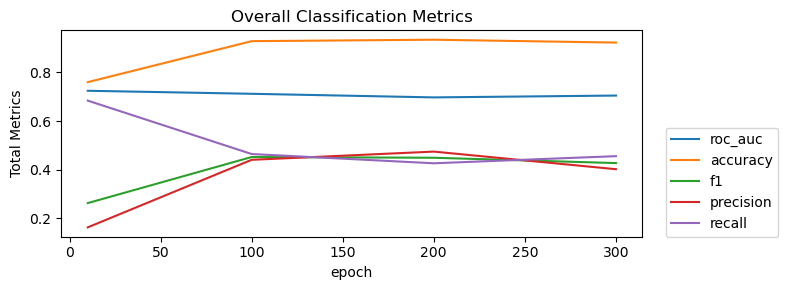

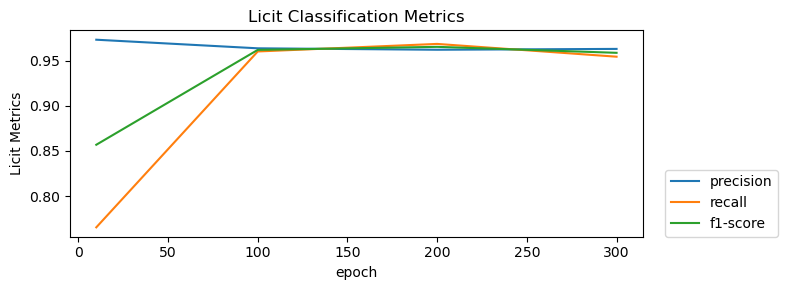

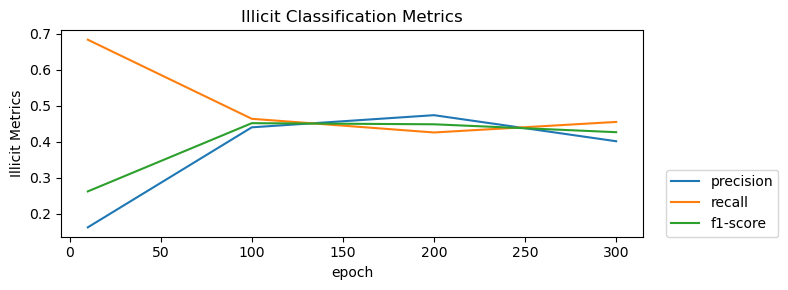

In [8]:
plot_metrics(metrics, para_list, para_change, x_log=False)